In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
# load the macro data
df = pd.io.parsers.read_csv('./Data/macro.csv',parse_dates=['timestamp'])
print(df.shape) #number of rowm, number of columns

(2484, 100)


# Data Types

In [7]:
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").agg('count')

Count
Column Type          
datetime64[ns]      1
int64               2
float64            94
object              3

non numerical columns

In [8]:
df.select_dtypes(include=['O']).dropna().head()

child_on_acc_pre_school modern_education_share old_education_build_share
1096                   3,013                  90,92                     23,14
1097                   3,013                  90,92                     23,14
1098                   3,013                  90,92                     23,14
1099                   3,013                  90,92                     23,14
1100                   3,013                  90,92                     23,14

These are % numbers. We replace "," with '.', then change to numeric.

In [9]:
for col in df.select_dtypes(include=['O']).columns.tolist():
    df[col] = df[col].apply(lambda s: str(s).replace(',','.')).apply(pd.to_numeric, errors='coerce')

# Missing Values

In [10]:
# columns with full values
df.columns[-df.isnull().any()].tolist() 

['timestamp',
 'oil_urals',
 'gdp_annual',
 'gdp_annual_growth',
 'average_provision_of_build_contract',
 'deposits_value',
 'mortgage_value',
 'mortgage_rate',
 'fixed_basket']

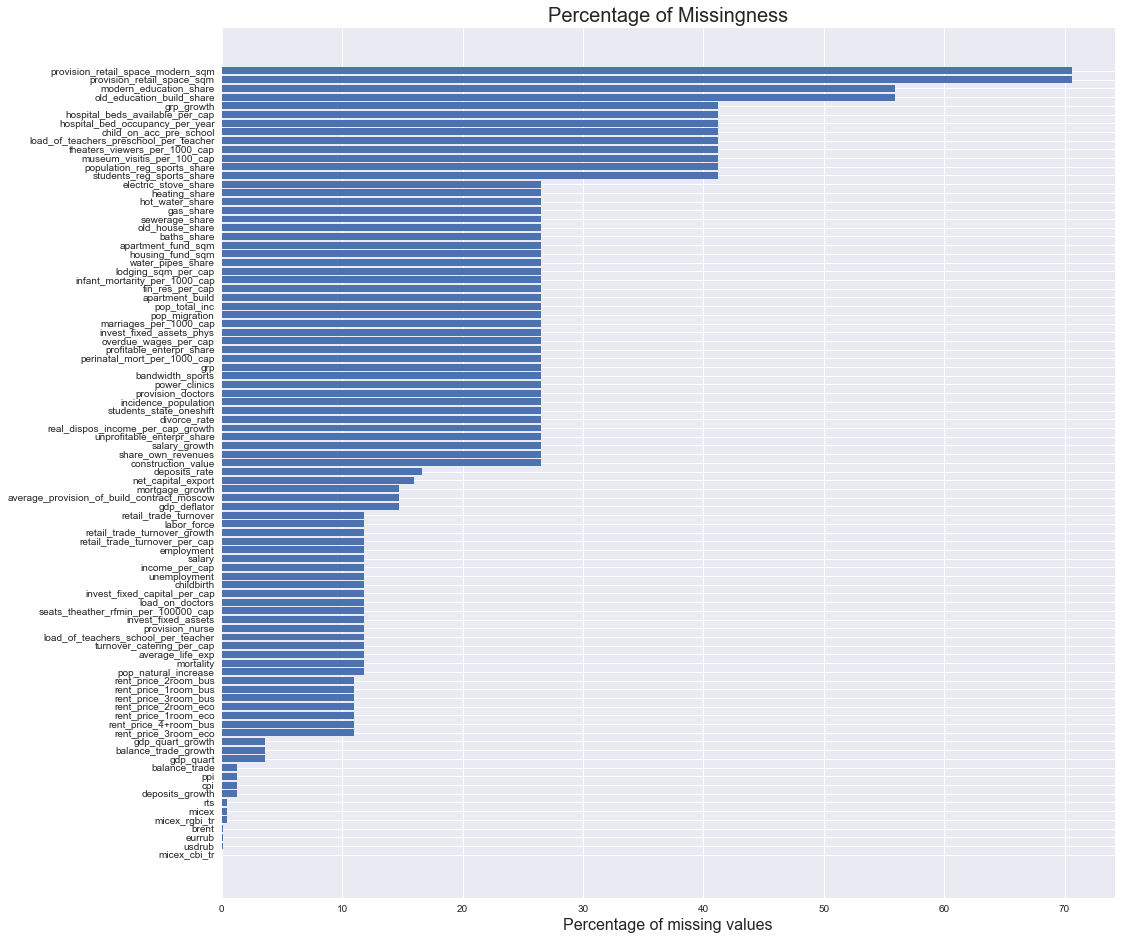

In [11]:
# columns with missing values, check percantage of missingness
nan_df = pd.DataFrame(columns=['colname', 'cnt'])
nan_df['colname'] =  df.columns[df.isnull().any()].tolist() 
nan_df['cnt'] = nan_df.colname.apply( lambda x : df[x].isnull().sum(axis=0)*100.0/len(df))
nan_df.sort_values(by='cnt', inplace = True)
f, ax = plt.subplots(figsize= (16,16))
idx = range(len(nan_df))
ax.barh( idx , nan_df.cnt.values )
ax.set_yticks(idx)
ax.set_yticklabels(nan_df.colname.values)
ax.set_title('Percentage of Missingness', fontsize = 20)
ax.set_xlabel("Percentage of missing values", fontsize = 16)
plt.show()

# The periods of the macro data 

In [12]:
cols      = df.columns.tolist()
df_period = pd.DataFrame(index = cols, columns = ['period'])

for col in cols:
    df_cnt = df.loc[df.timestamp<=pd.to_datetime('2015-12-31'),col].value_counts().value_counts().reset_index()
    df_cnt.columns = ['period', 'counts']
    period = 'none'
    df_cnt = df_cnt.astype(int)

    if max(df_cnt.period)<28:
        period = 'daily'
    elif set(df_cnt.period).issubset(set([365,366,730,731,1096])):
        period = 'annual'
    elif set(df_cnt.period).issubset(set([90,91,92,182,181,182,183,184])):
        period = 'quarterly'
    elif set(df_cnt.period).issubset(set([28,29,30,31,60,61,62,90,91,92,93,123,152,153])):
        period = 'monthly'   
    elif set(df_cnt.period).issubset(set([1,28,29,30,31,60,61,62,90,91,92,93,123,152,153])):
        period = 'mostly monthly' # monthly with 1-day-violation each year， 
    df_period.loc[col, 'period'] = period 
    
df_period.period.value_counts()

annual            67
monthly           18
daily              8
quarterly          5
mostly monthly     2
Name: period, dtype: int64

##### Most of the macro data are annual and monthly.

# Plots existing and new features

In [13]:
# load the macro data and get the monthly median 
df['year'] = df.timestamp.dt.year
df['month'] = df.timestamp.dt.month
df['quarter'] = df.timestamp.dt.quarter
df['yearmonth'] = df['year'].apply(lambda x :'{0:04d}'.format( x))+ df['month'].apply(lambda x :'{0:02d}'.format( x))
df['yearquarter'] = df['year'].apply(lambda x :'{0:04d}'.format( x))+'Q'+ df['quarter'].apply(lambda x :'{0:01d}'.format( x))

### Columns with period = daily

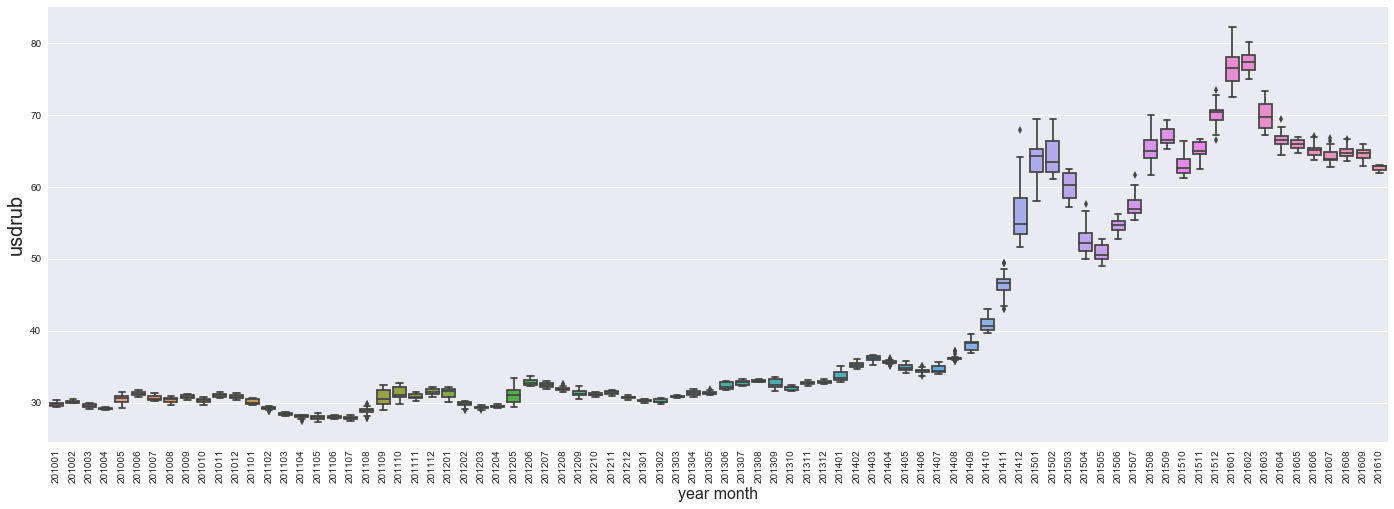

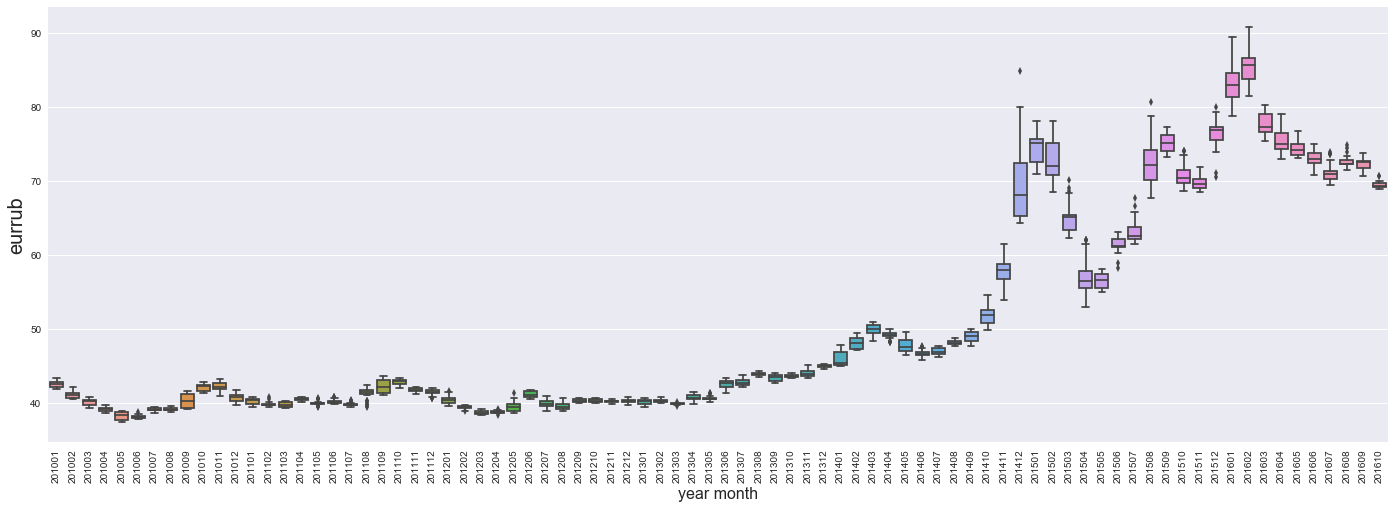

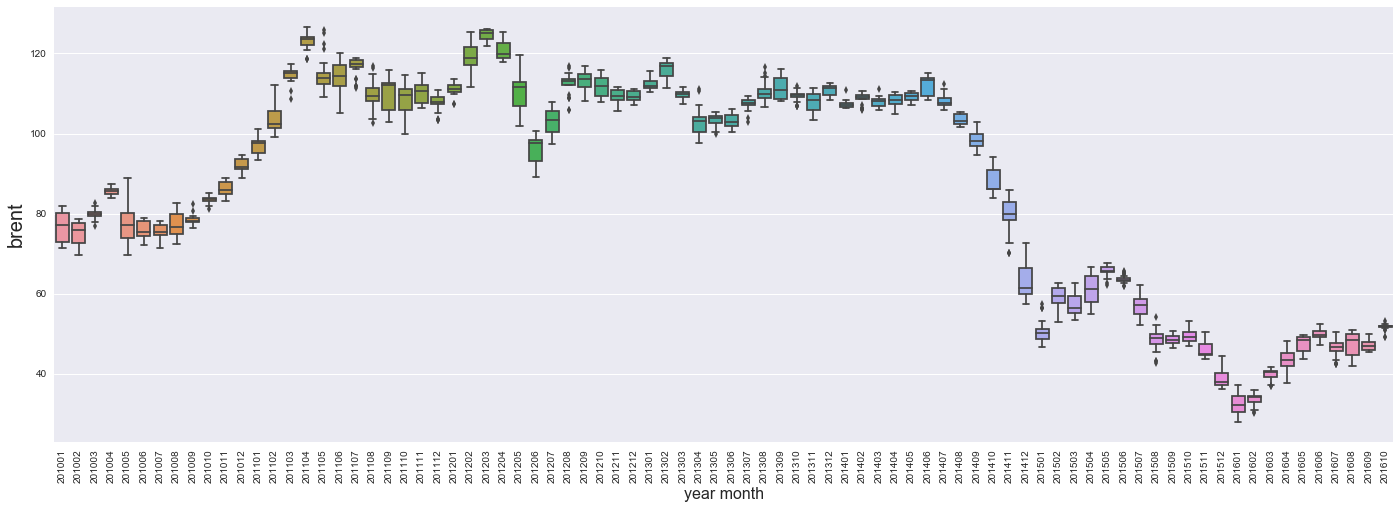

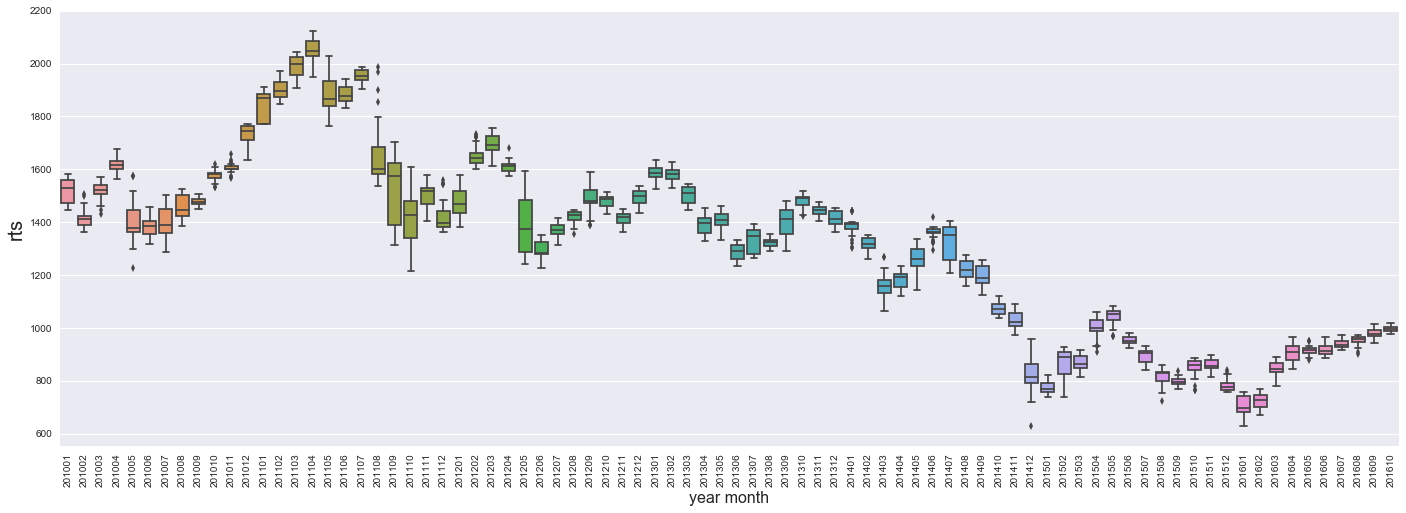

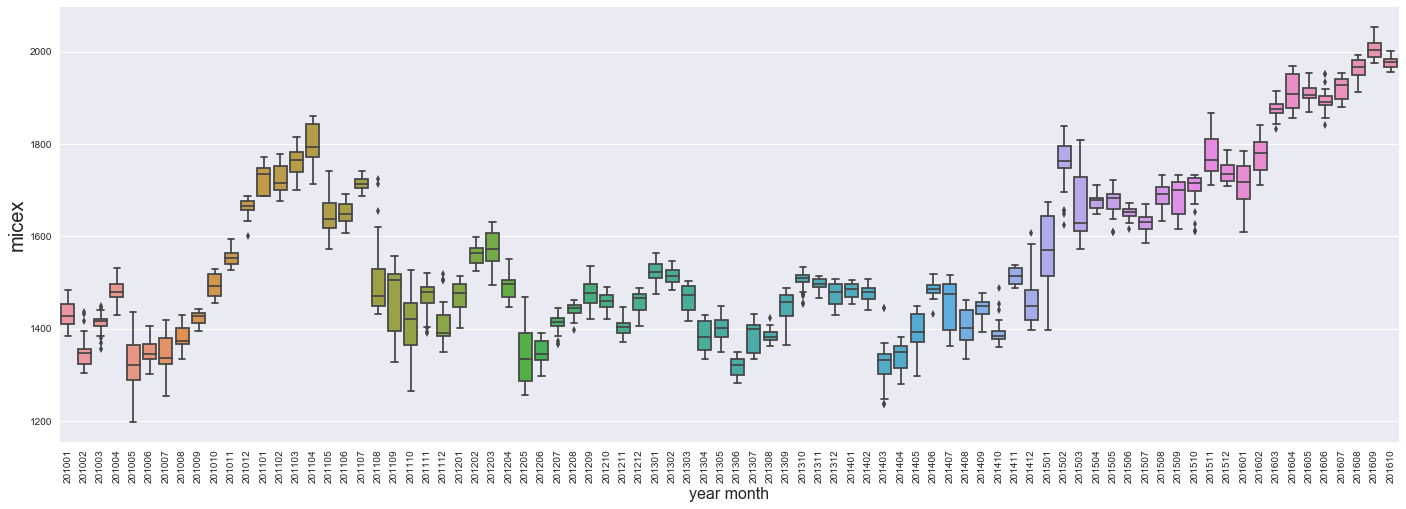

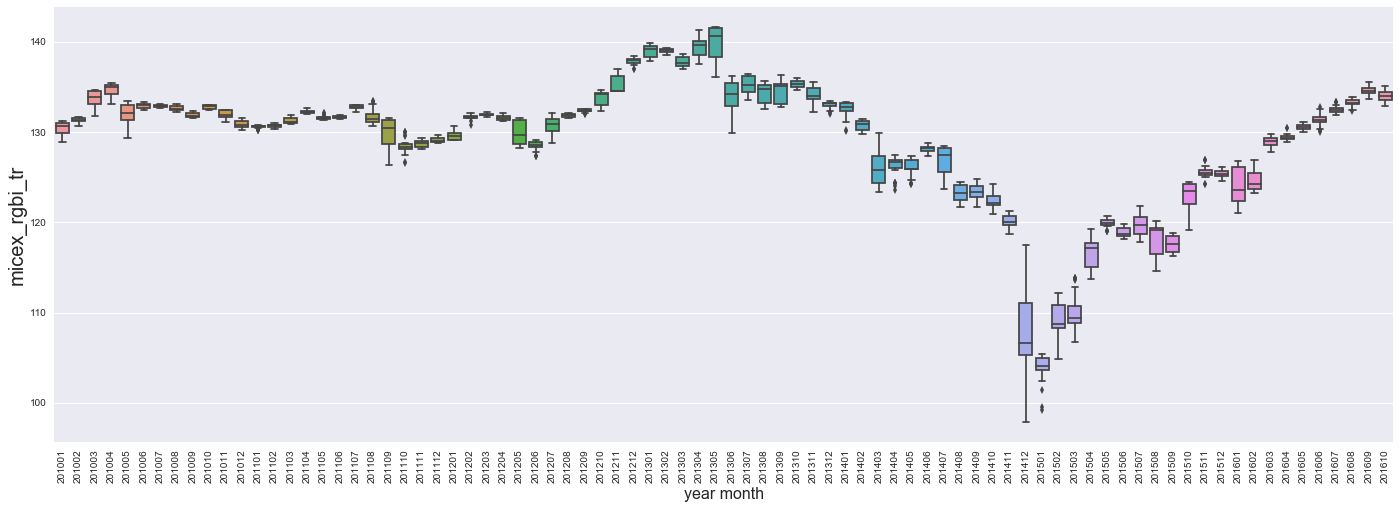

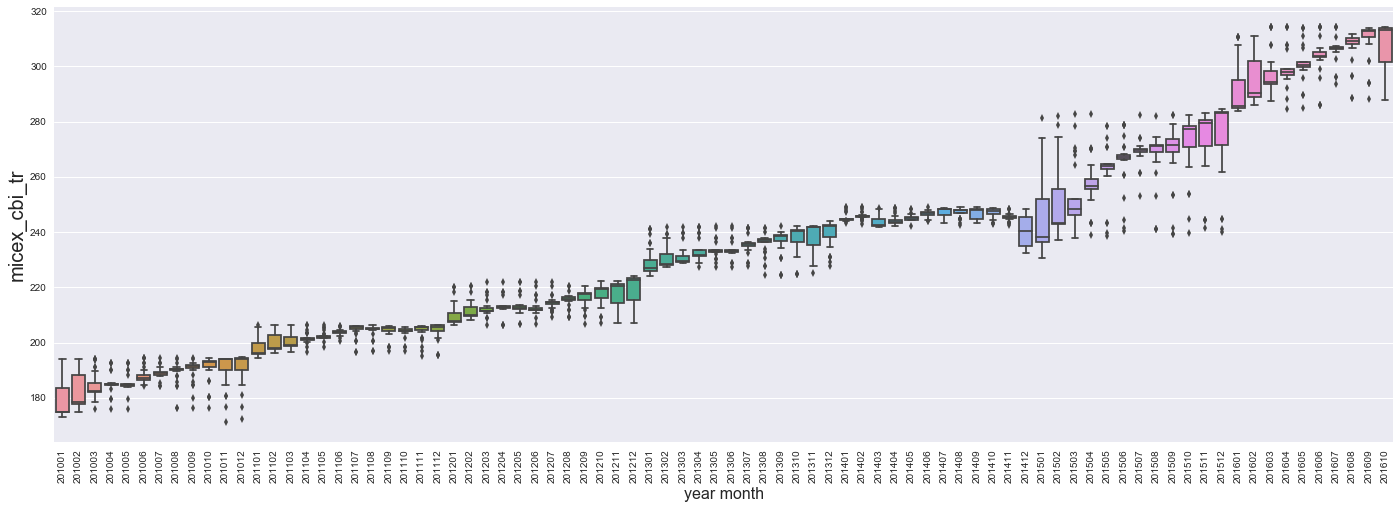

In [14]:
dailycol =  df_period.index[df_period['period'] == 'daily'][1:]
for col in dailycol:
    plt.figure(figsize=(24,8))
    sns.boxplot(x='yearmonth', y=col, data=df)
    plt.xlabel('year month', fontsize = 16)
    plt.ylabel(col, fontsize = 20)
    plt.xticks(rotation='vertical')
    plt.show()

## Oil Index in Ruble
I like these because they are a combination of the oil price change (in USD) and currency reaction (between US and Russia). Energy represents more than half of Russian exports. http://atlas.media.mit.edu/en/profile/country/rus/ The Russian goverment has adjusted its currency value to shiled its domestic market againt the oil crash started in 2014.

In [15]:
# new daily features
df['oil_rub']   = df['usdrub']*df['oil_urals']
df['brent_rub'] = df['usdrub']*df['brent']
df['usdeur'] = df['usdrub']/df['eurrub']

df['oil_rub_cpi'] = df['oil_rub']*df['cpi']

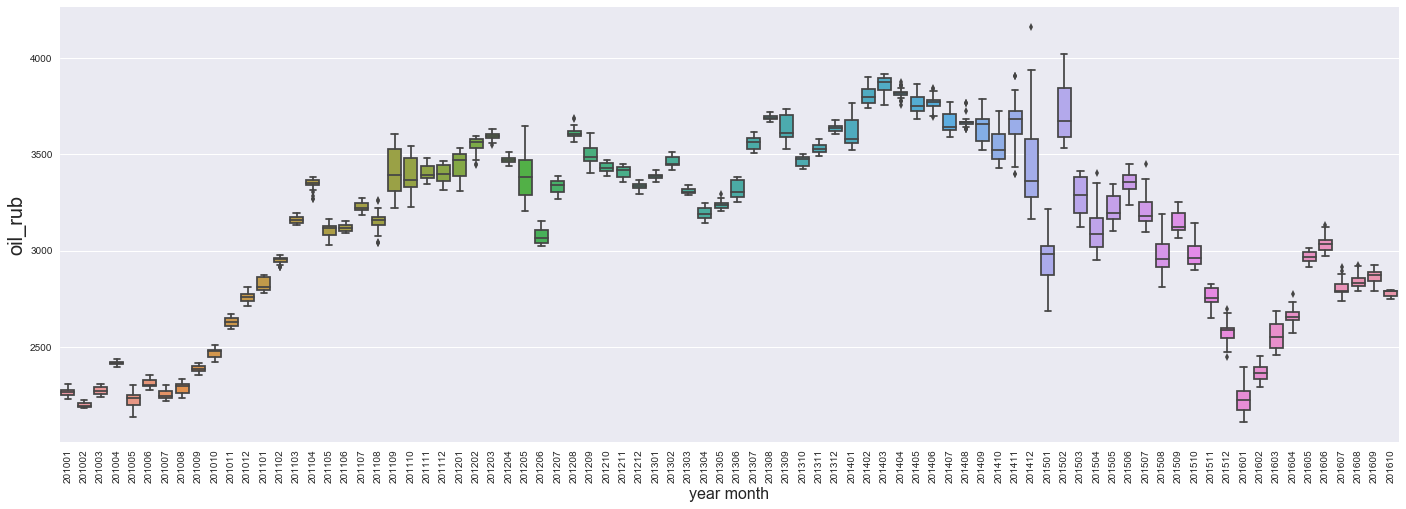

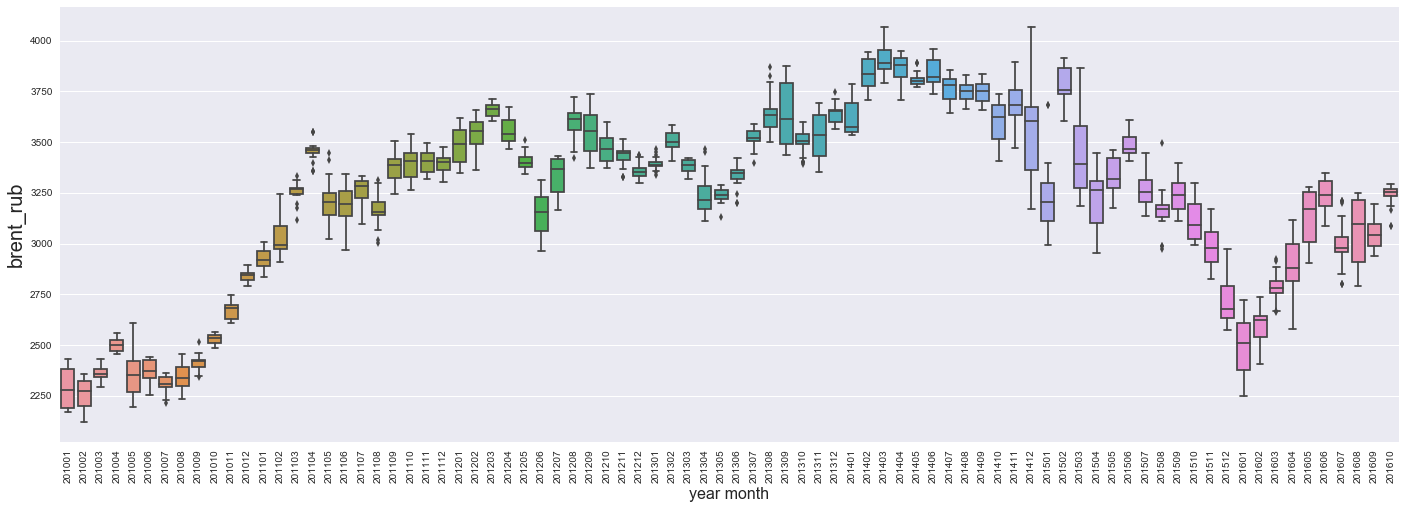

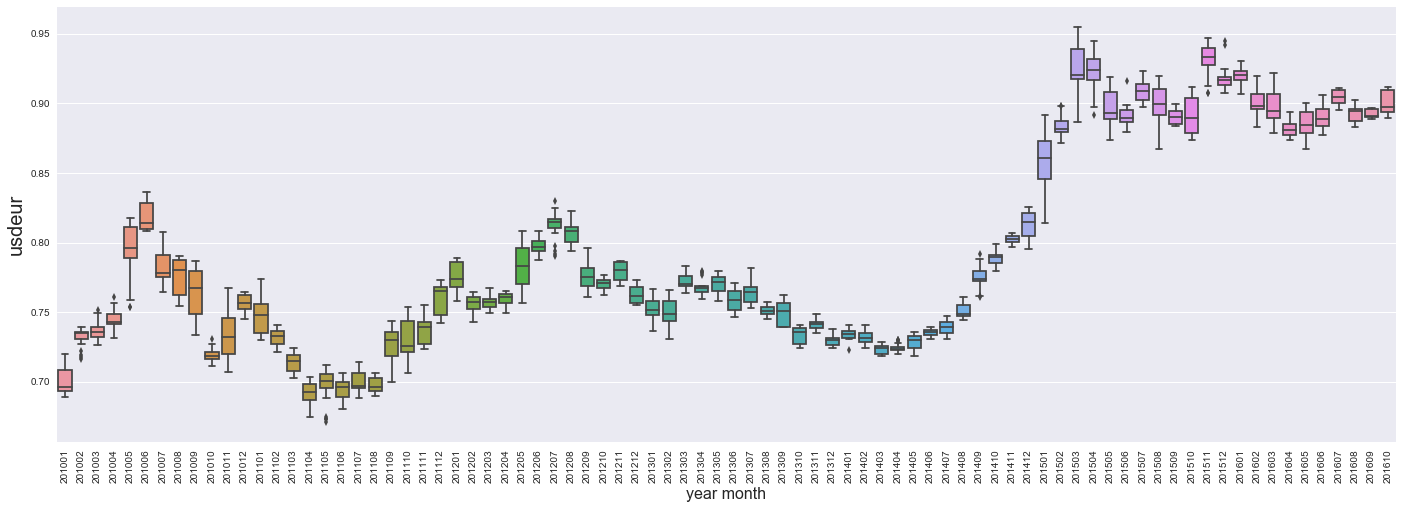

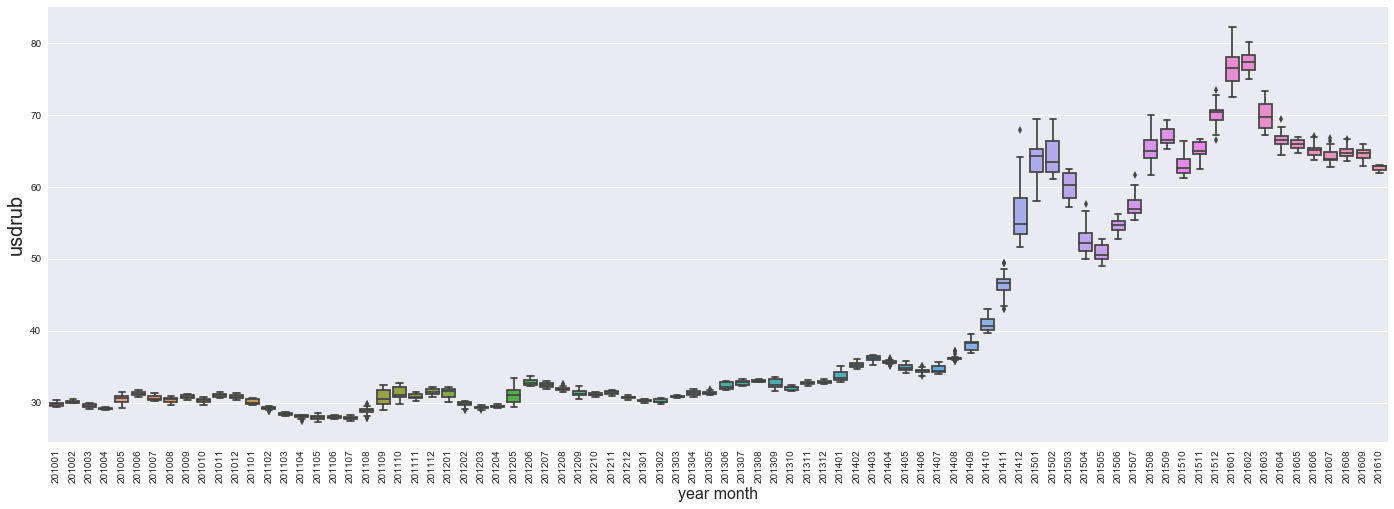

In [16]:
# Urals in Ruble
col = 'oil_rub'
plt.figure(figsize=(24,8))
sns.boxplot(x='yearmonth', y=col, data=df)
plt.xlabel('year month', fontsize = 16)
plt.ylabel(col, fontsize = 20)
plt.xticks(rotation='vertical')
plt.show()

# Brent in Ruble
col = 'brent_rub'
plt.figure(figsize=(24,8))
sns.boxplot(x='yearmonth', y=col, data=df)
plt.xlabel('year month', fontsize = 16)
plt.ylabel(col, fontsize = 20)
plt.xticks(rotation='vertical')
plt.show()

# eur to usd
col = 'usdeur'
plt.figure(figsize=(24,8))
sns.boxplot(x='yearmonth', y=col, data=df)
plt.xlabel('year month', fontsize = 16)
plt.ylabel(col, fontsize = 20)
plt.xticks(rotation='vertical')
plt.show()
# usdrub
col = 'usdrub'
plt.figure(figsize=(24,8))
sns.boxplot(x='yearmonth', y=col, data=df)
plt.xlabel('year month', fontsize = 16)
plt.ylabel(col, fontsize = 20)
plt.xticks(rotation='vertical')
plt.show()

### Columns with period = monthly

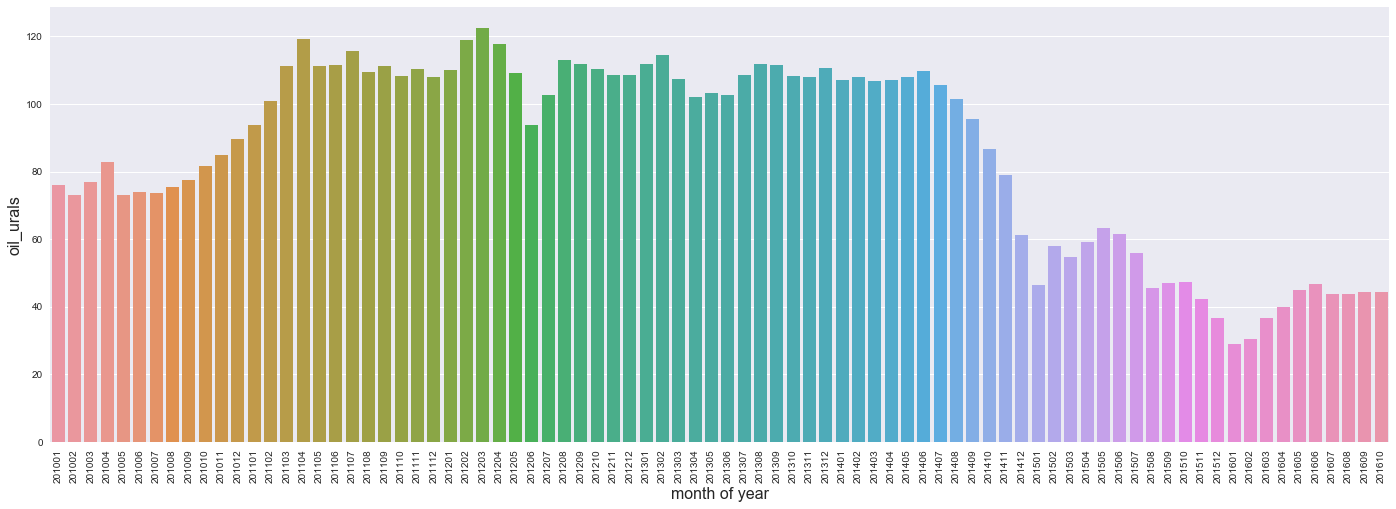

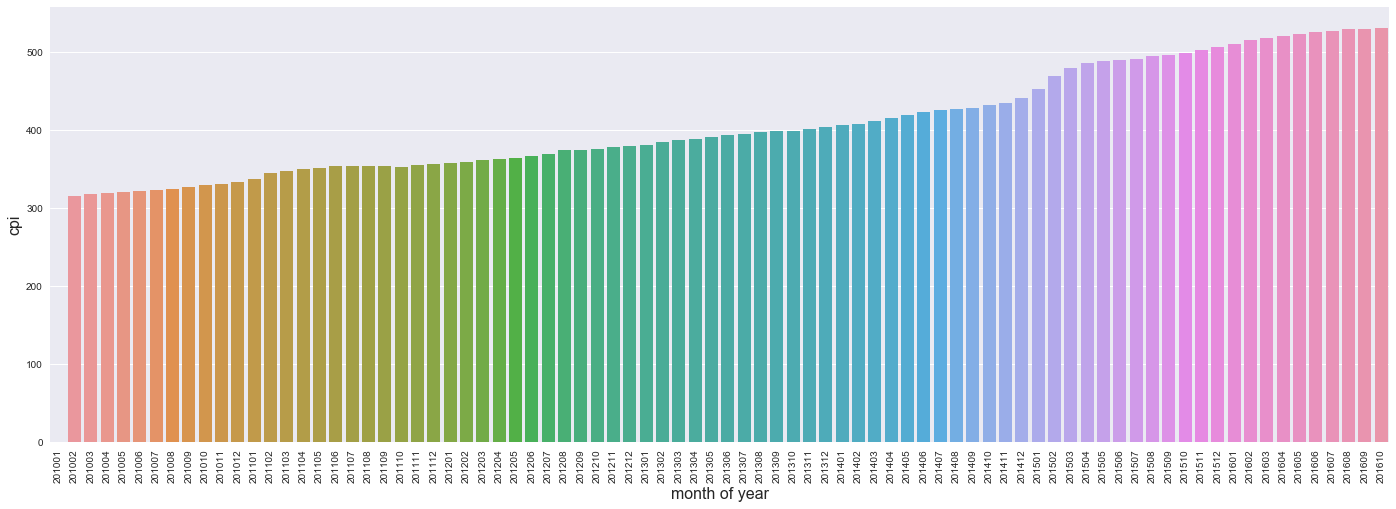

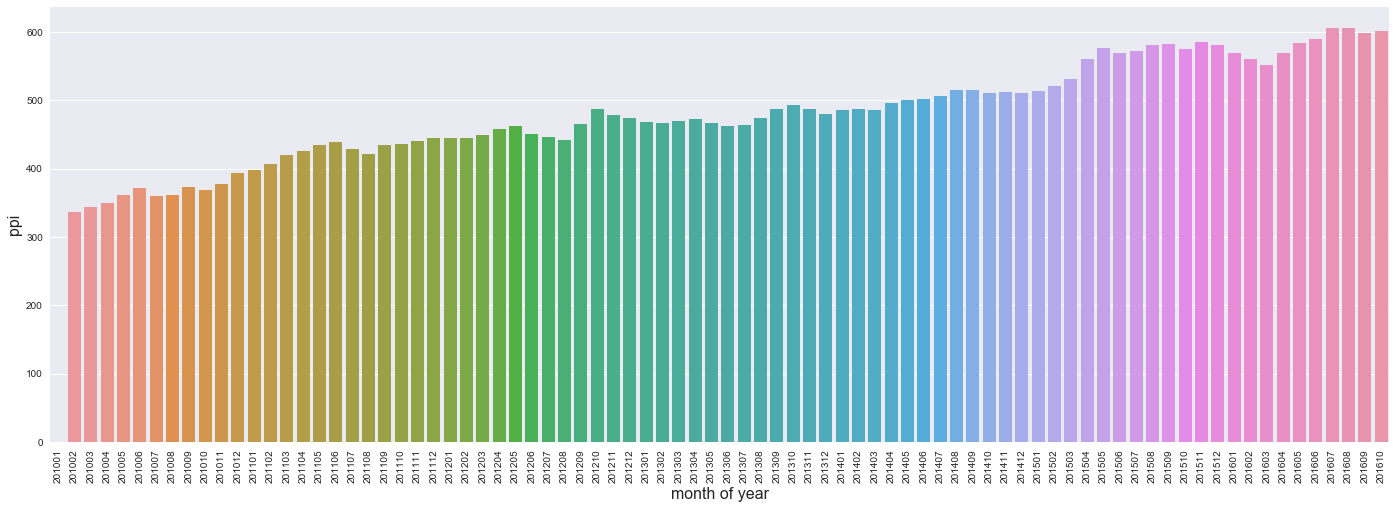

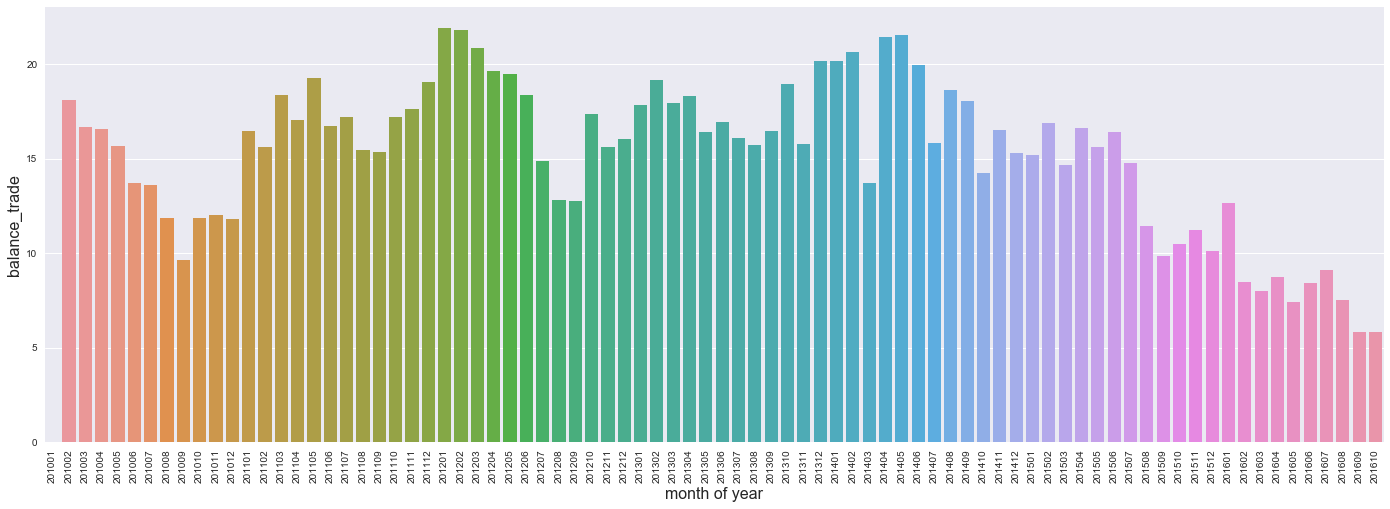

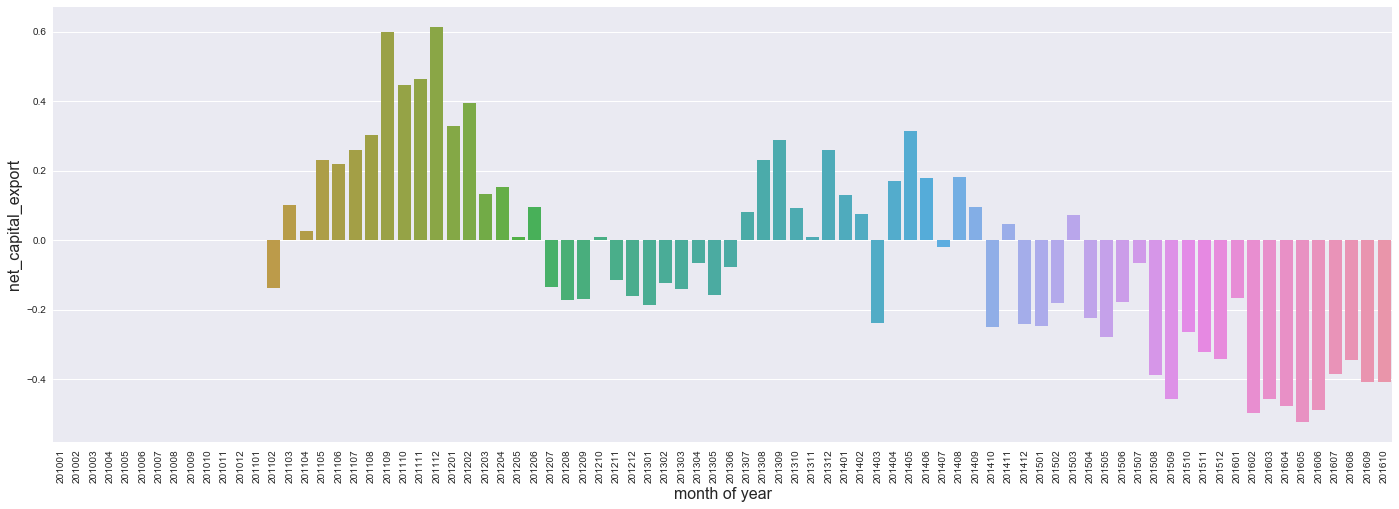

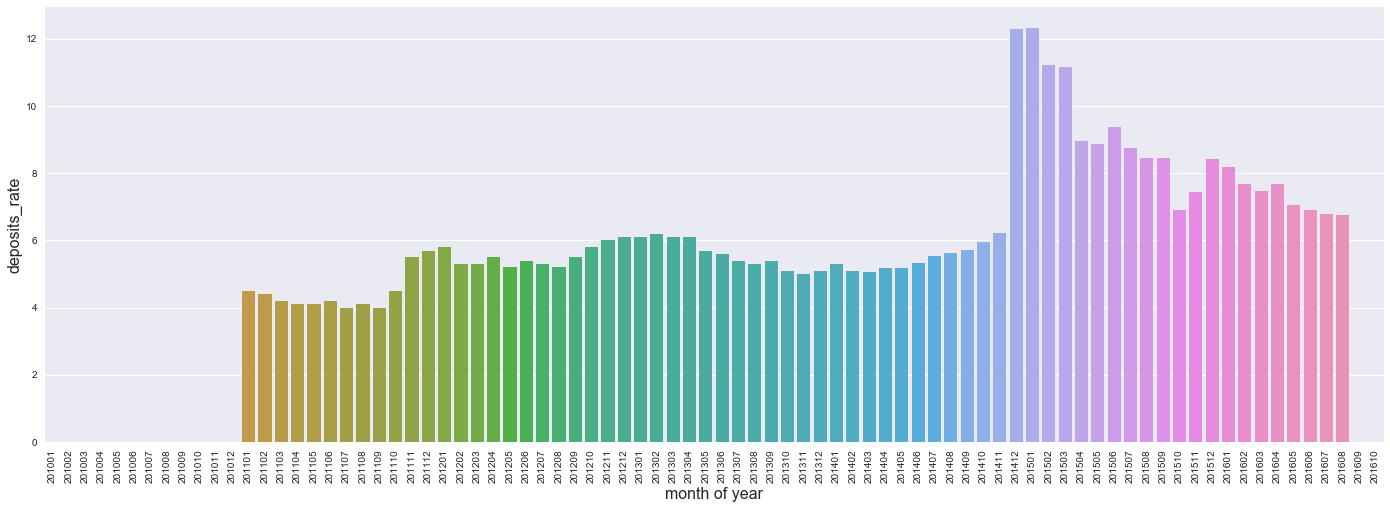

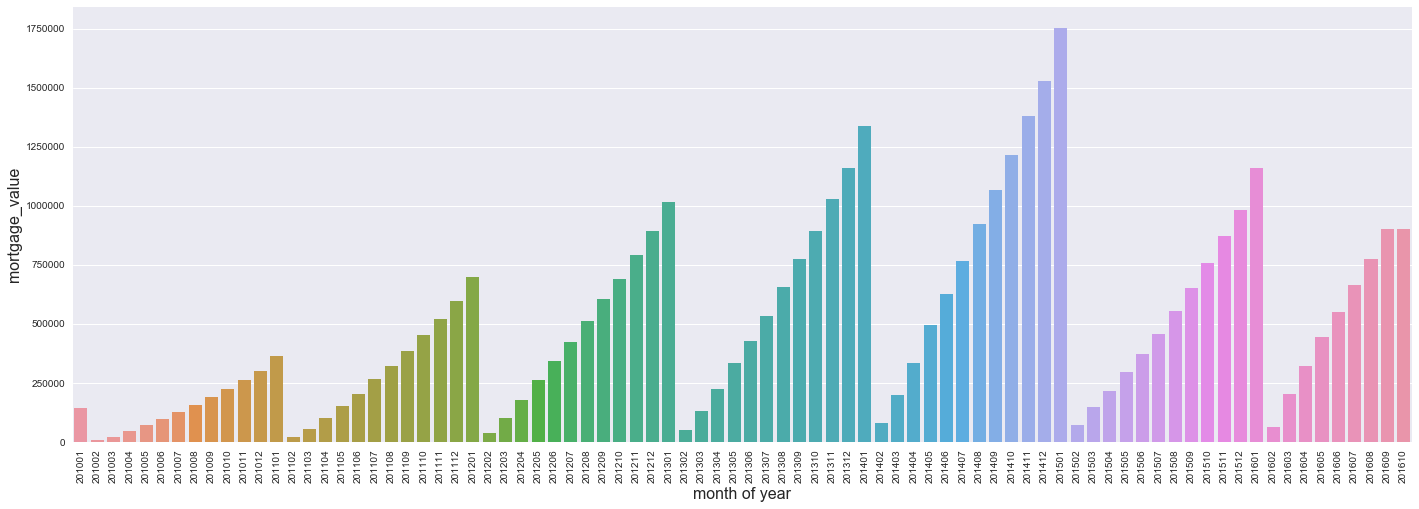

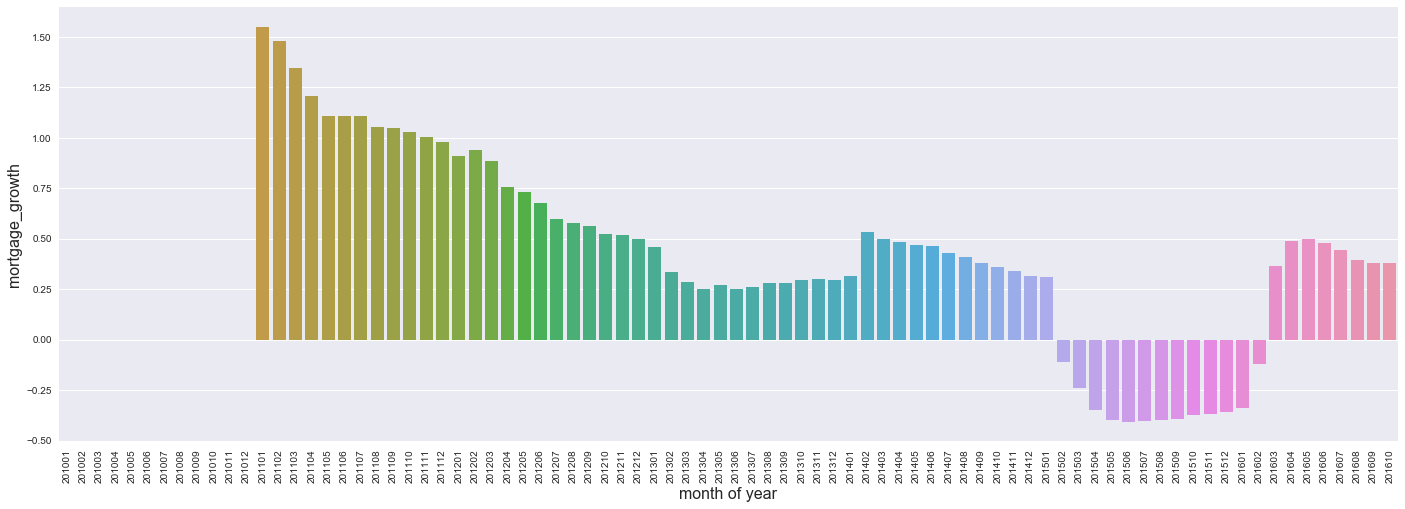

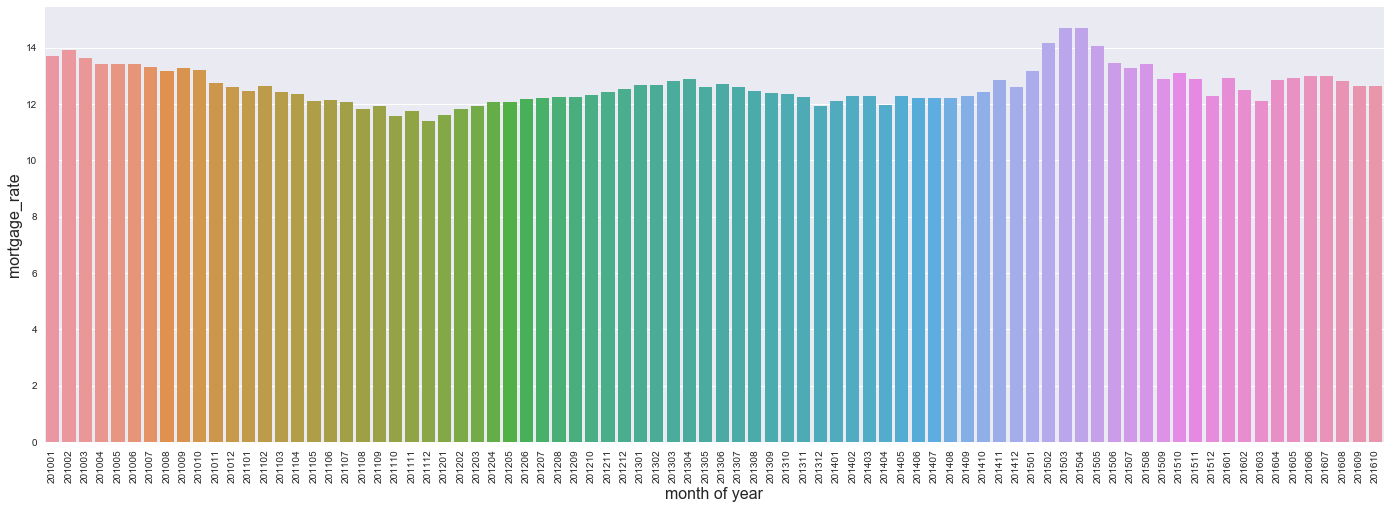

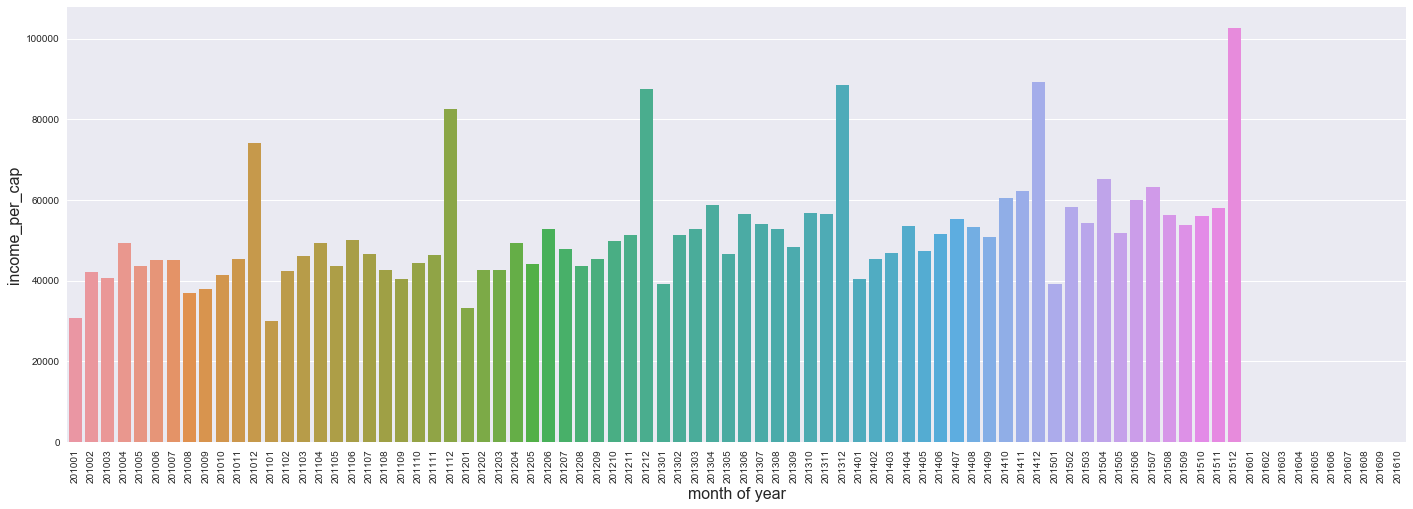

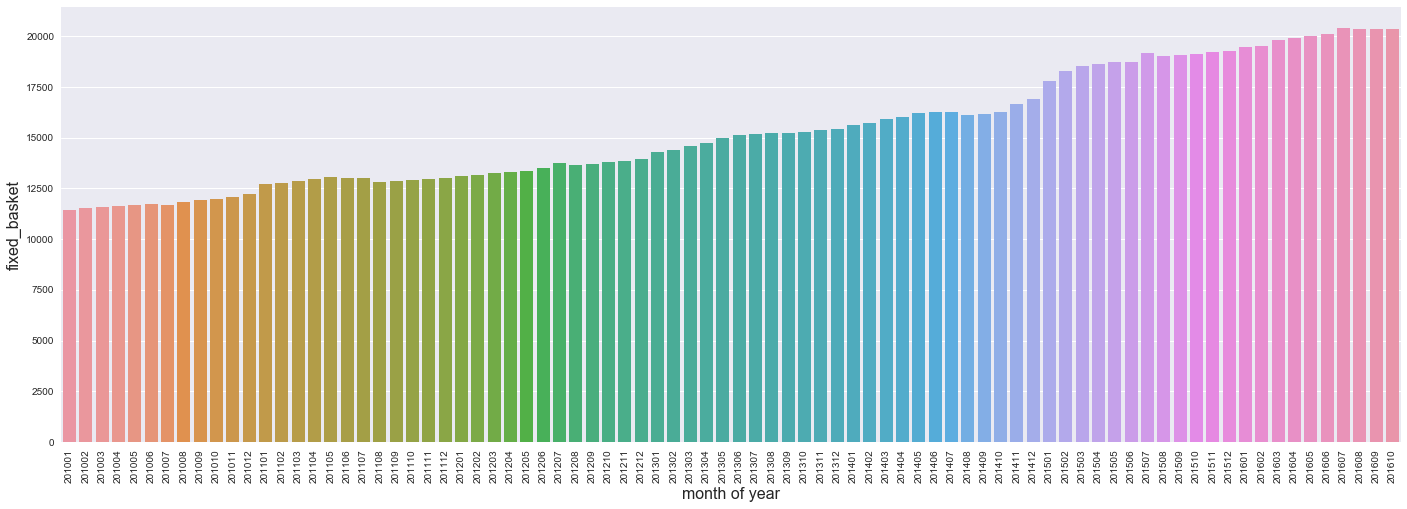

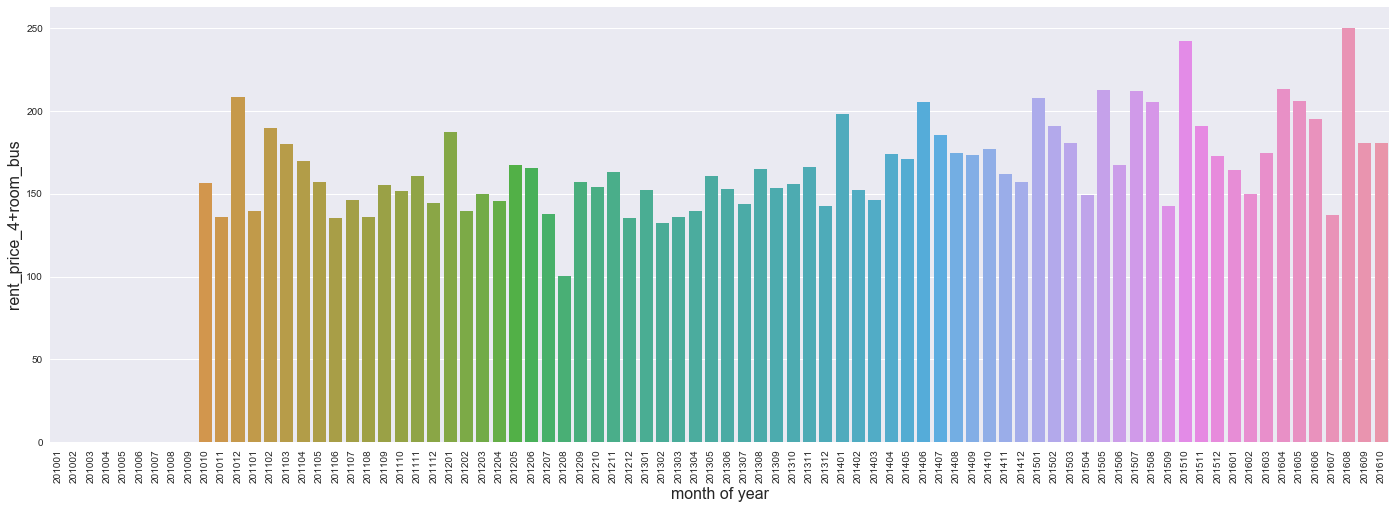

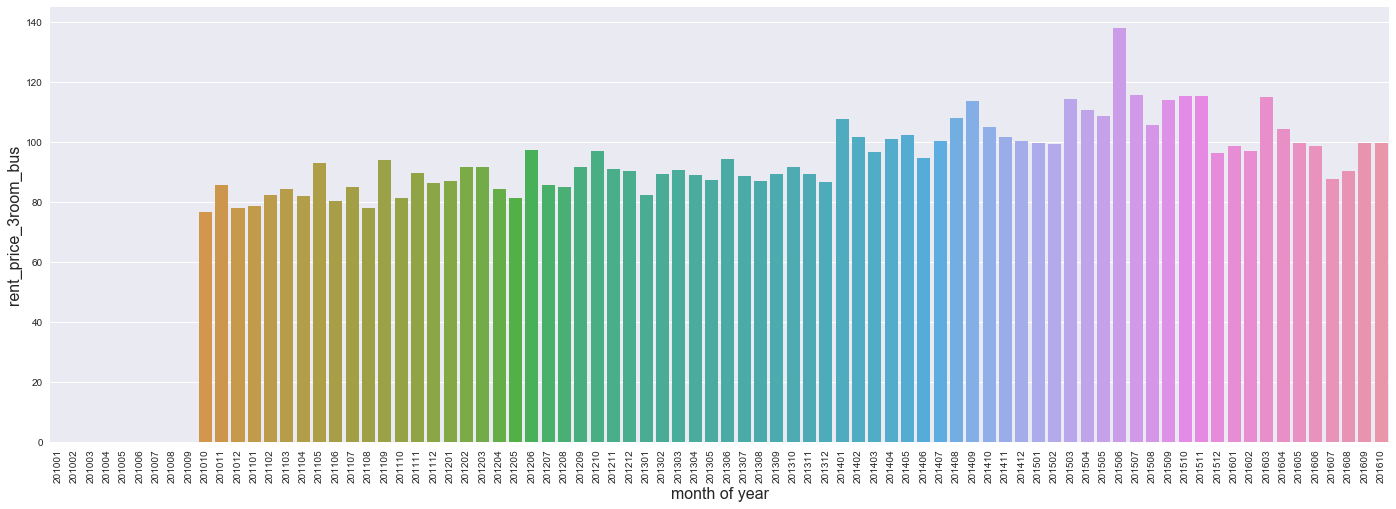

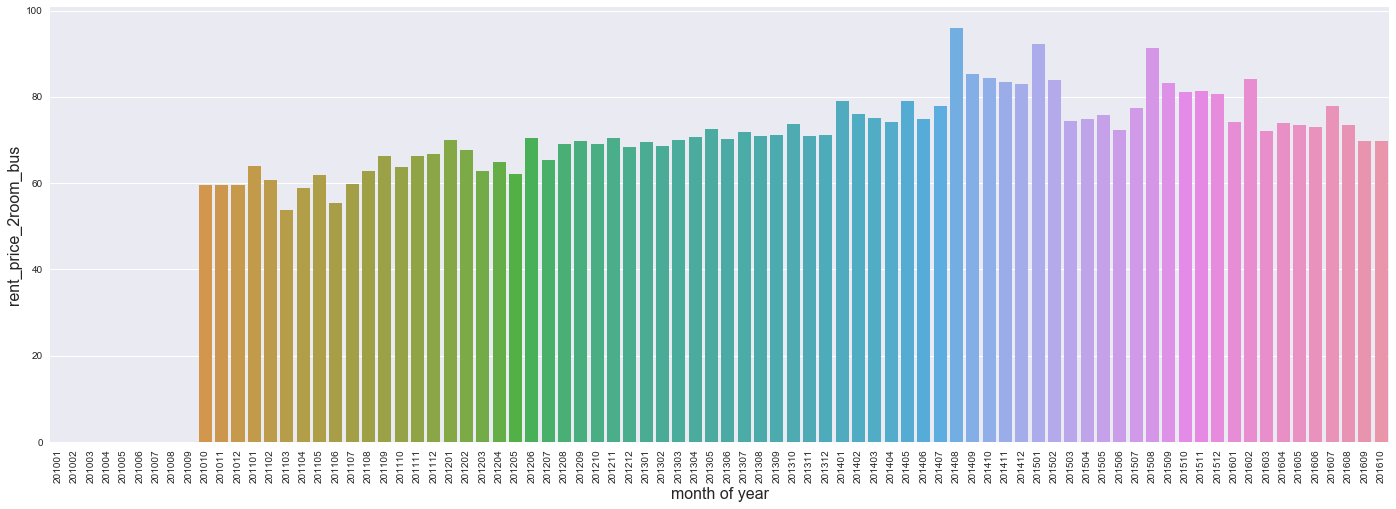

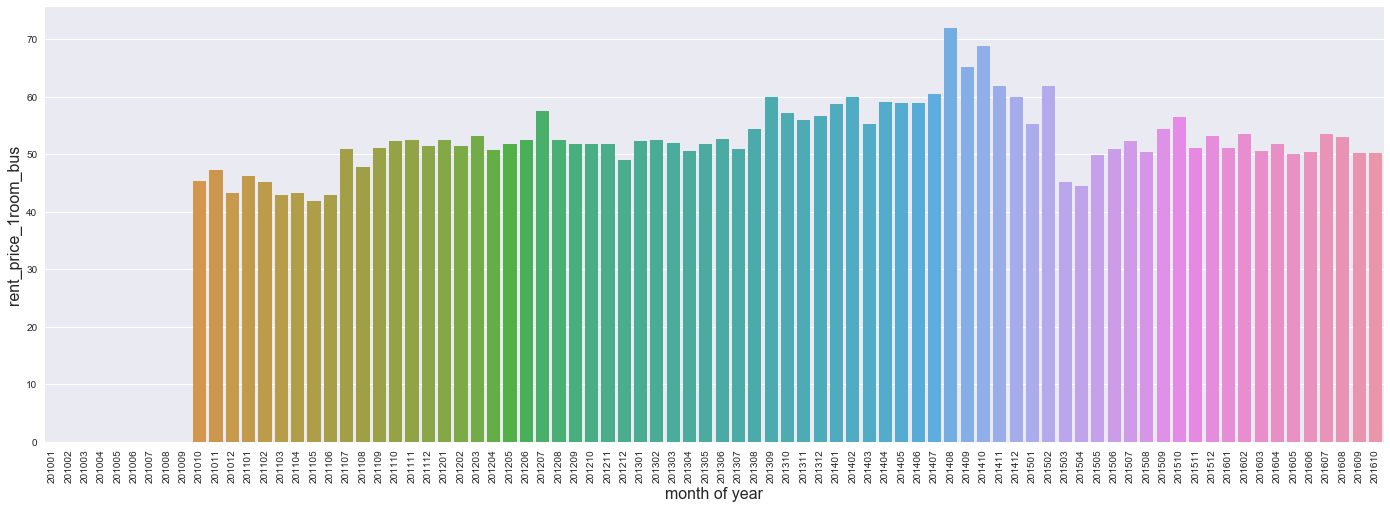

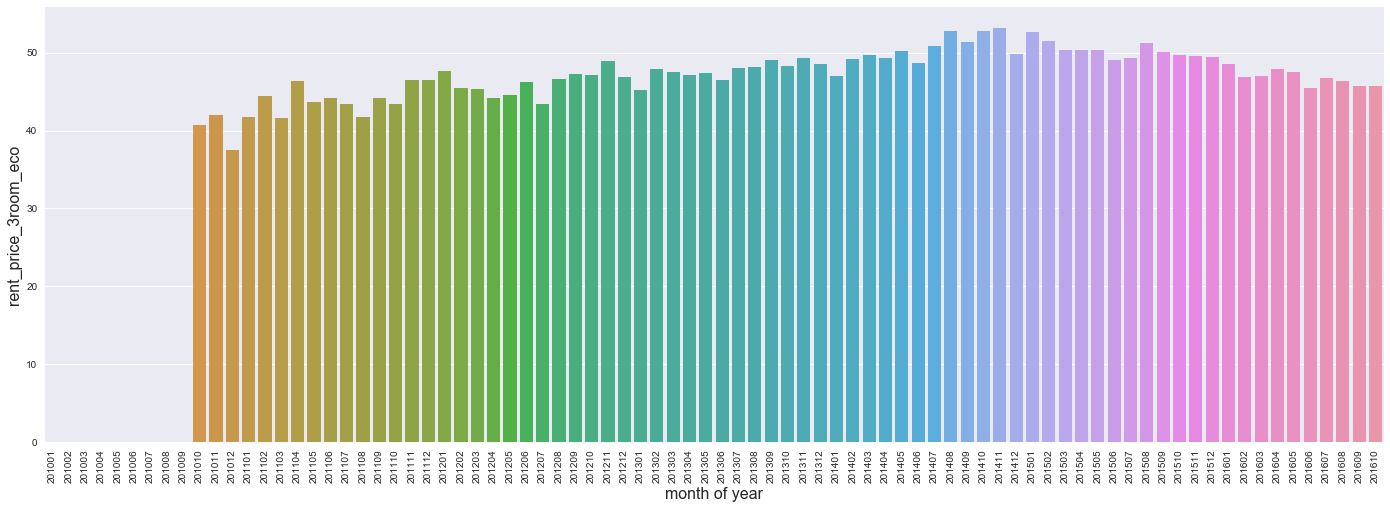

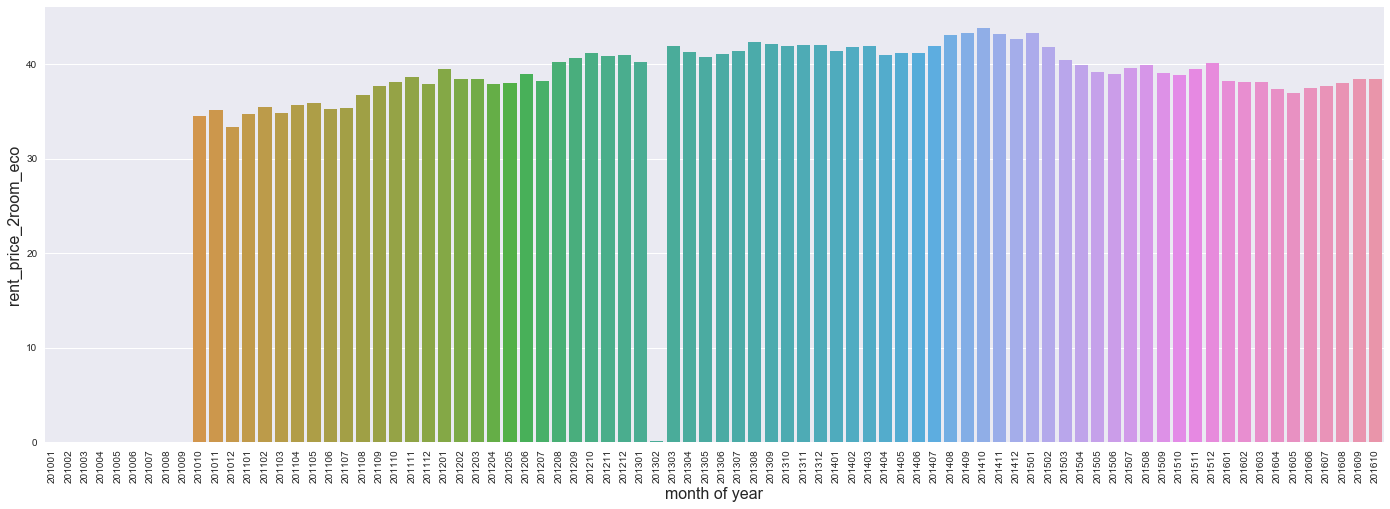

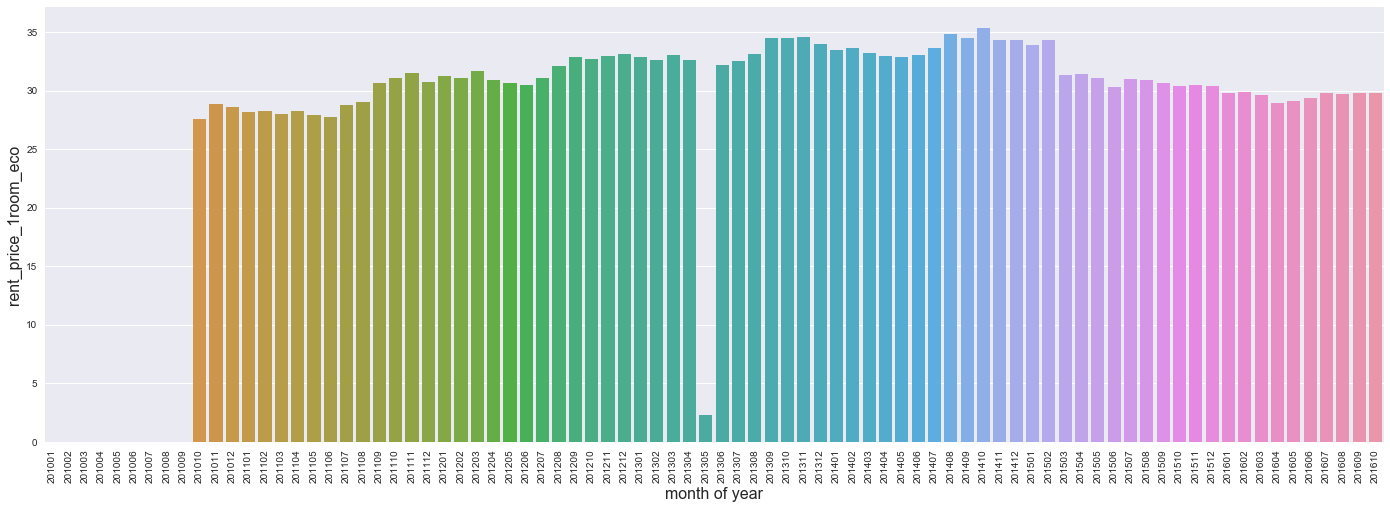

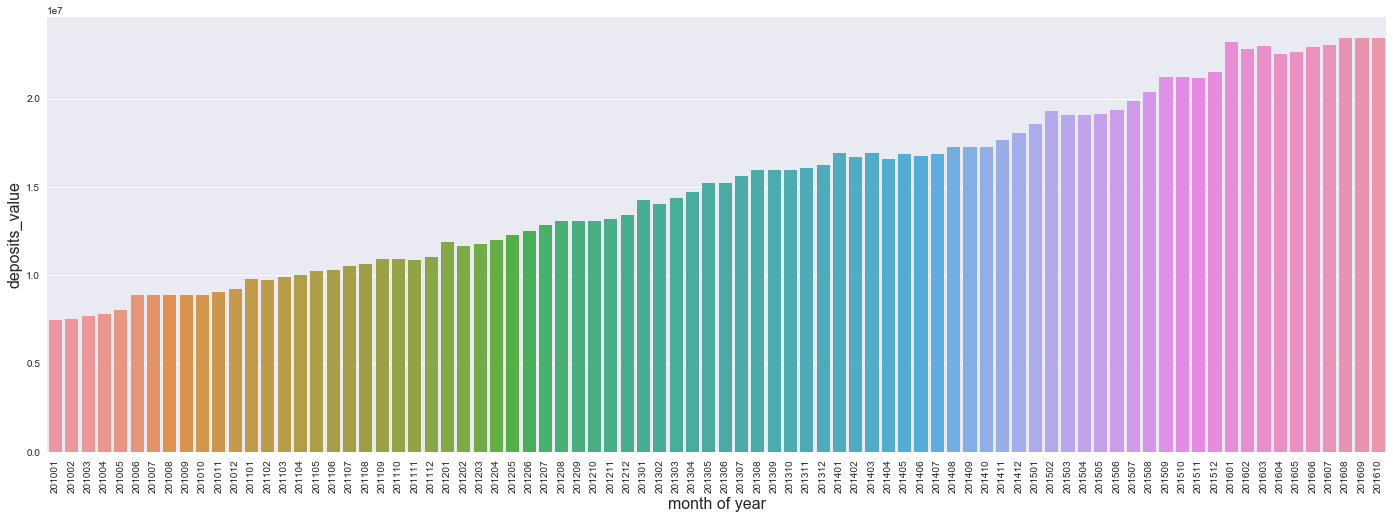

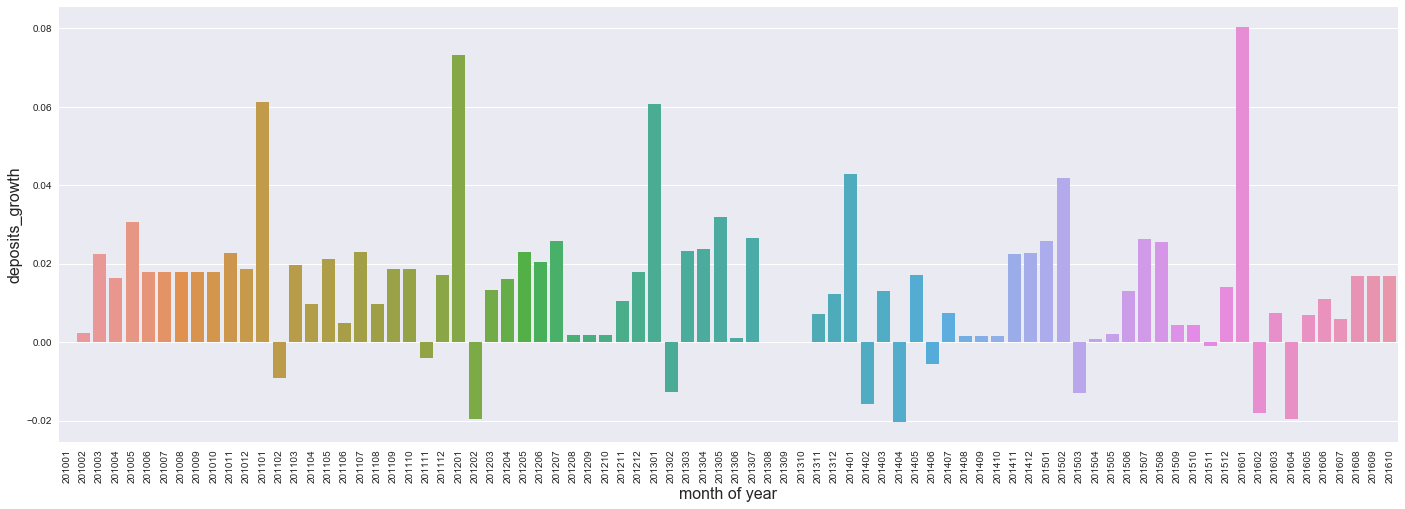

In [17]:
df_median = df.groupby(['yearmonth']).agg(np.median).reset_index()
monthlycol =  df_period.index[df_period['period'] == 'monthly'].tolist() + df_period.index[df_period['period'] == 'mostly monthly'].tolist()

for col in monthlycol:
    plt.figure(figsize=(24,8))
    sns.barplot(x='yearmonth', y= col, data = df_median)
    plt.xlabel('month of year', fontsize = 16)
    plt.ylabel(col, fontsize = 16)
    plt.xticks(rotation='vertical')
    plt.show()

### columns with period = 'quarterly'

In [18]:
df_quarter = df.groupby(['yearquarter']).aggregate(np.median).reset_index()
quarterlycol =  df_period.index[df_period['period'] == 'quarterly'].tolist()

# for col in quarterlycol:
#     plt.figure(figsize=(24,8))
#     sns.barplot(x='yearquarter', y= col, data = df_quarter)
#     plt.xlabel('quarter of year', fontsize = 16)
#     plt.ylabel(col, fontsize = 16)
#     plt.xticks(rotation='vertical')
#     plt.show()

### Columns with period = 'annual'

In [19]:
df_year = df.groupby(['year']).aggregate(np.median).reset_index()
annualcol =  df_period.index[df_period['period'] == 'annual'].tolist()

# for col in annualcol:
#     plt.figure(figsize=(6,3))
#     sns.barplot(x='year', y= col, data = df_year)
#     plt.xlabel('year', fontsize = 16)
#     plt.ylabel(col, fontsize = 16)
#     plt.xticks(rotation='vertical')
#     plt.show()

# Plots with price_doc 

In [20]:
# load the price_doc in train.csv
train = pd.io.parsers.read_csv('./Data/train_clean_shu_lonlat_CS_0518.csv')
train['yearmonth'] = train.timestamp.apply(lambda x :x[:4] +x[5:7])
train_median = train.groupby(['yearmonth']).agg(np.median).reset_index()

In [21]:
# merge the median of price_doc for each month to the monthly macro data
df_median = pd.merge(df_median, train_median[['yearmonth','price_doc','unit_price']], on = 'yearmonth', how = 'left')

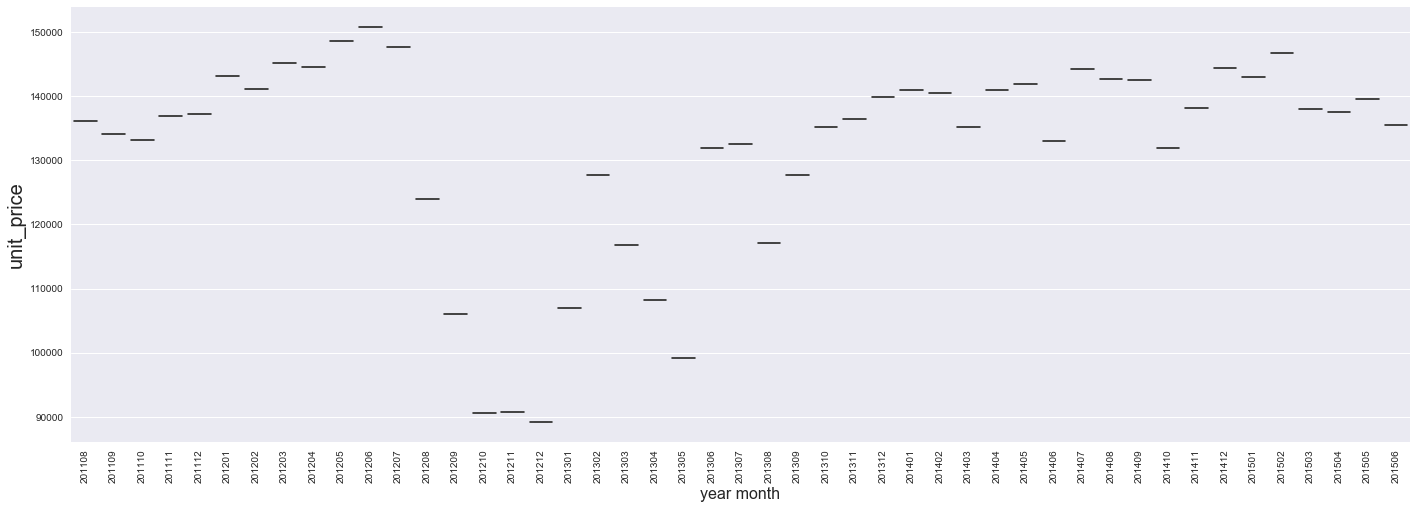

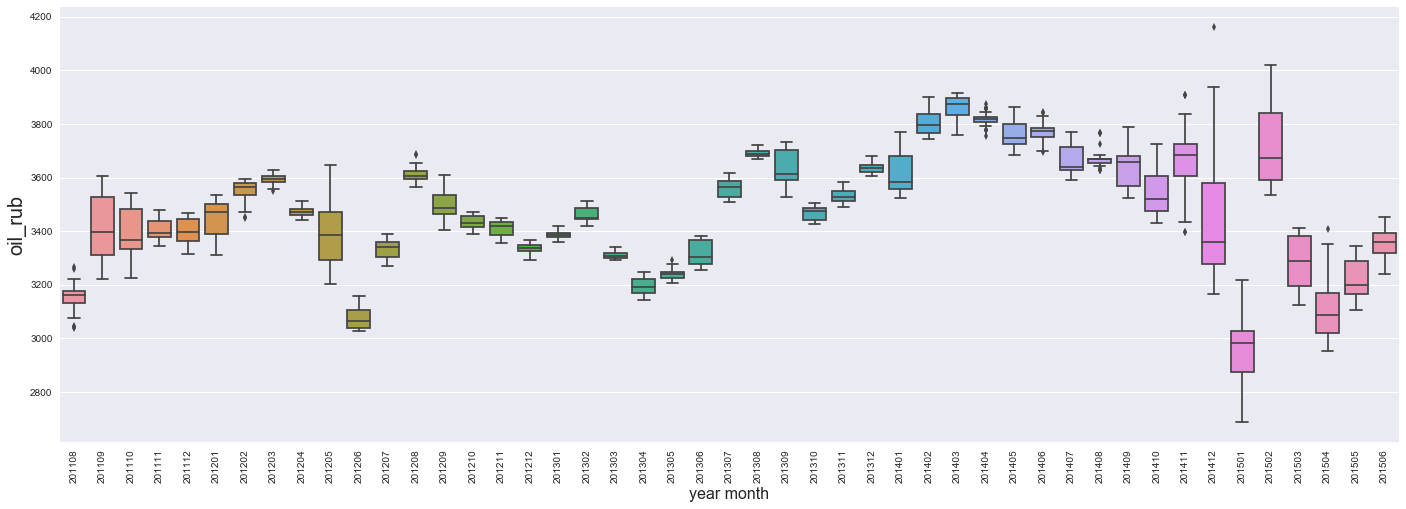

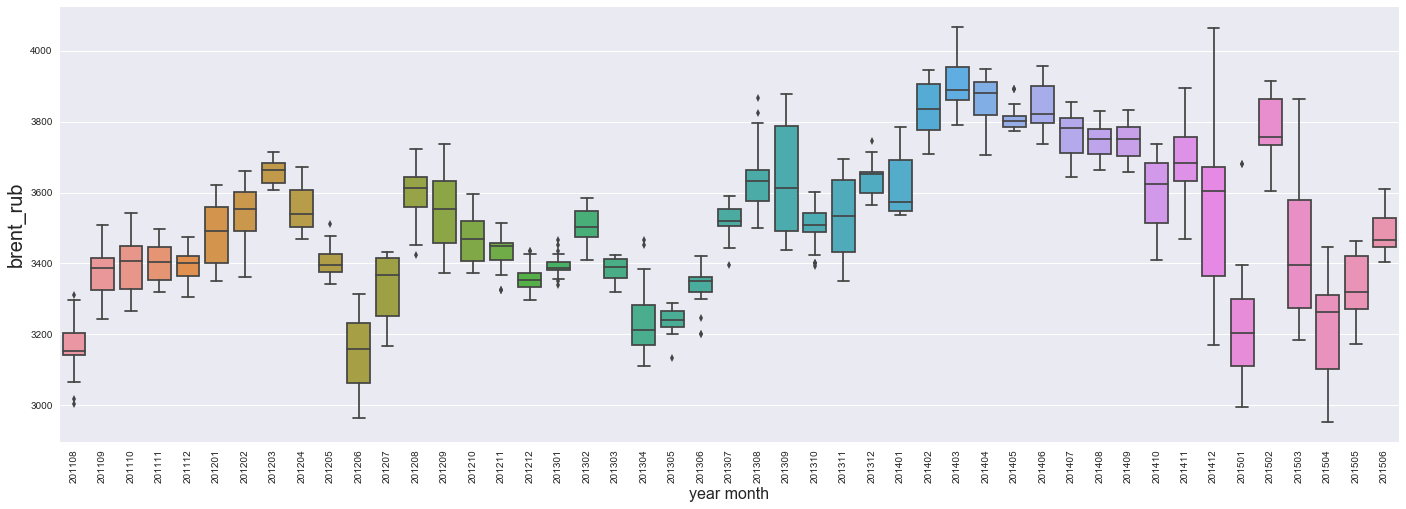

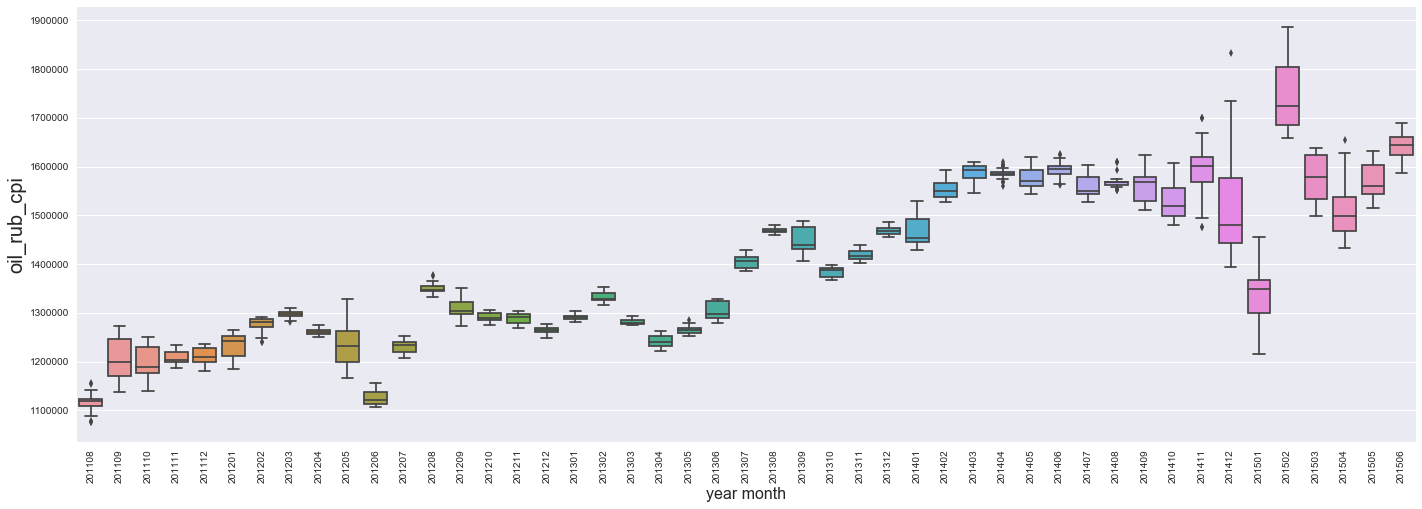

In [22]:
col = 'unit_price'
plt.figure(figsize=(24,8))
sns.boxplot(x='yearmonth', y=col, data=train_median)
plt.xlabel('year month', fontsize = 16)
plt.ylabel(col, fontsize = 20)
plt.xticks(rotation='vertical')
plt.show()

col = 'oil_rub'
macro_1108_1506 = df.loc[(df.timestamp<=pd.to_datetime('2015-06-30'))&(df.timestamp>=pd.to_datetime('2011-08-01')),:]
# macro_1108_1506 = df

plt.figure(figsize=(24,8))
sns.boxplot(x='yearmonth', y=col, data=macro_1108_1506)
plt.xlabel('year month', fontsize = 16)
plt.ylabel(col, fontsize = 20)
plt.xticks(rotation='vertical')
plt.show()

col = 'brent_rub'

plt.figure(figsize=(24,8))
sns.boxplot(x='yearmonth', y=col, data=macro_1108_1506)
plt.xlabel('year month', fontsize = 16)
plt.ylabel(col, fontsize = 20)
plt.xticks(rotation='vertical')
plt.show()

col = 'oil_rub_cpi'

plt.figure(figsize=(24,8))
sns.boxplot(x='yearmonth', y=col, data=macro_1108_1506)
plt.xlabel('year month', fontsize = 16)
plt.ylabel(col, fontsize = 20)
plt.xticks(rotation='vertical')
plt.show()

In [23]:
df_median.timestamp = pd.to_datetime(df_median.yearmonth,format='%Y%m')

In [24]:
df_median_1108_1506
df_median_1108_1506 = df_median.loc[(df_median.timestamp<=pd.to_datetime('2015-06-30'))&\
                                (df_median.timestamp>=pd.to_datetime('2011-08-01')),:]
plt.xcorr(df_median_1108_1506['unit_price'],df_median_1108_1506['oil_rub'],normed=True)
plt.xcorr(df_median_1108_1506['unit_price'],df_median_1108_1506['oil_rub'],normed=True)
plt.xcorr(df_median_1108_1506['unit_price'],df_median_1108_1506['brent_rub'],normed=True)

NameError: name 'df_median_1108_1506' is not defined

In [25]:
#  from skimage.feature import match_template
# match_template(df_median_1108_1506['unit_price'],df_median_1108_1506['oil_rub'])

In [26]:
import math

In [27]:
df.corr()

oil_urals  gdp_quart  \
oil_urals                                    1.000000  -0.443855   
gdp_quart                                   -0.443855   1.000000   
gdp_quart_growth                             0.723601  -0.730279   
cpi                                         -0.730893   0.831981   
ppi                                         -0.567825   0.870779   
gdp_deflator                                -0.831245   0.854641   
balance_trade                                0.756507  -0.197946   
balance_trade_growth                         0.089046   0.155917   
usdrub                                      -0.896539   0.711289   
eurrub                                      -0.870997   0.730896   
brent                                        0.994865  -0.449051   
net_capital_export                           0.739094  -0.577075   
gdp_annual                                  -0.466691   0.921975   
gdp_annual_growth                            0.595329   0.190069   
average_provision_of_build_contract          0.008522   0.789152   
average_provision_of_build_contract_moscow  -0.597975   0.388703   
rts                                          0.793046  -0.746291   
micex                                       -0.597442   0.354670   
micex_rgbi_tr                                0.484667  -0.458994   
micex_cbi_tr                                -0.626605   0.817760   
deposits_value                              -0.631176   0.883214   
deposits_growth                             -0.028001  -0.106324   
deposits_rate                               -0.754838   0.695846   
mortgage_value                              -0.144630   0.551237   
mortgage_growth                              0.632358  -0.766370   
mortgage_rate                               -0.584762   0.080472   
grp                                          0.428092   0.916308   
grp_growth                                   0.150744  -0.672754   
income_per_cap                              -0.244445   0.394508   
real_dispos_income_per_cap_growth           -0.146696  -0.470716   
...                                               ...        ...   
load_of_teachers_preschool_per_teacher       0.807779   0.911502   
child_on_acc_pre_school                     -0.814045  -0.751731   
load_of_teachers_school_per_teacher         -0.442691   0.877538   
students_state_oneshift                     -0.142825   0.116492   
modern_education_share                      -0.882778   0.650650   
old_education_build_share                    0.889017  -0.479859   
provision_doctors                            0.795558   0.670525   
provision_nurse                              0.541058  -0.806626   
load_on_doctors                              0.828428  -0.329420   
power_clinics                                0.216693  -0.542828   
hospital_beds_available_per_cap              0.448398  -0.785369   
hospital_bed_occupancy_per_year              0.431279  -0.831732   
provision_retail_space_sqm                   0.097439   0.752034   
provision_retail_space_modern_sqm           -0.938380  -0.830439   
turnover_catering_per_cap                   -0.280725   0.919949   
theaters_viewers_per_1000_cap                0.737900   0.914008   
seats_theather_rfmin_per_100000_cap          0.046690   0.654632   
museum_visitis_per_100_cap                   0.810437   0.899688   
bandwidth_sports                            -0.828357   0.827409   
population_reg_sports_share                 -0.397694   0.791715   
students_reg_sports_share                    0.461721   0.777215   
apartment_build                              0.385645   0.851396   
apartment_fund_sqm                          -0.582655   0.194324   
year                                        -0.585199   0.897778   
month                                        0.011389  -0.041885   
quarter                                      0.010863  -0.040851   
oil_rub                                      0.596808   0.306260   
brent_rub                       

In [28]:
df_median.yearmonth.dtype

dtype('O')

## log-log plots

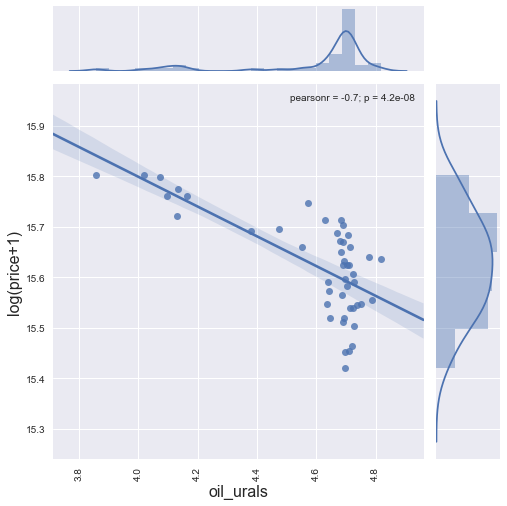

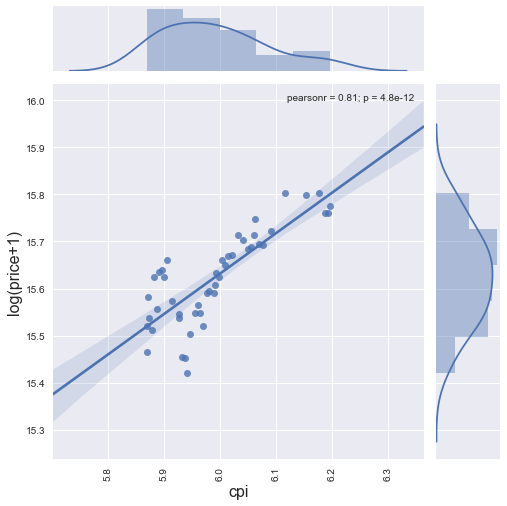

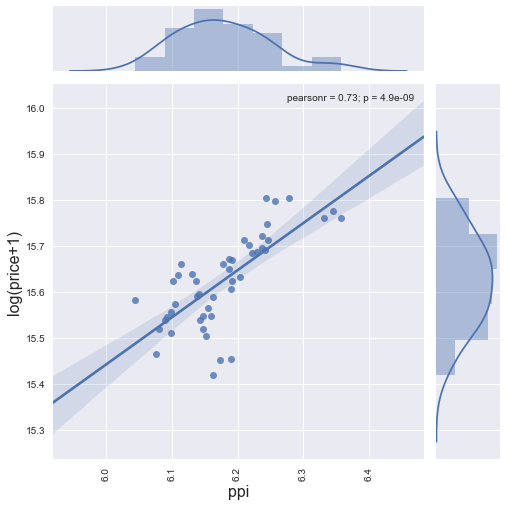

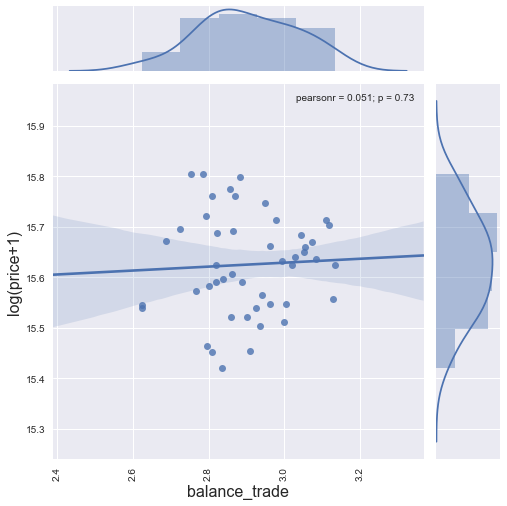

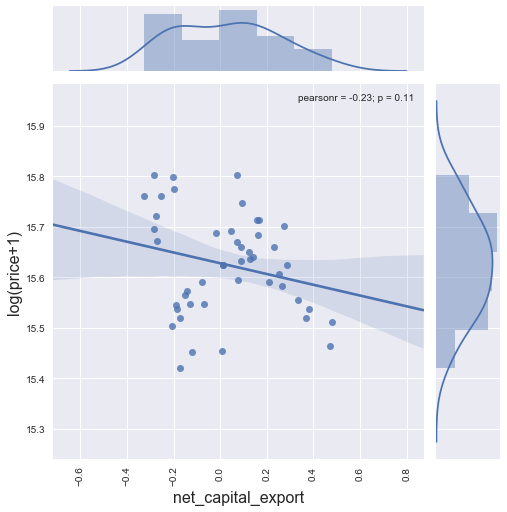

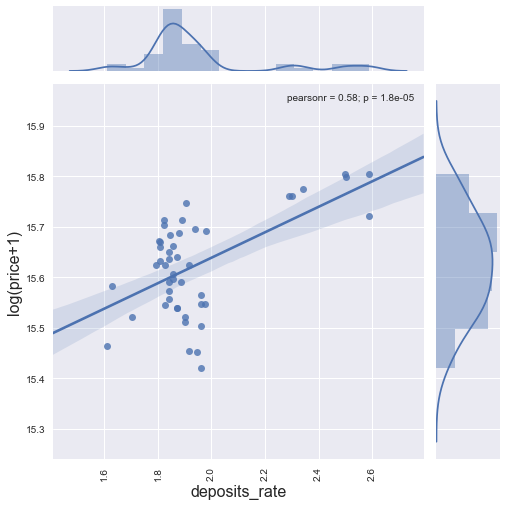

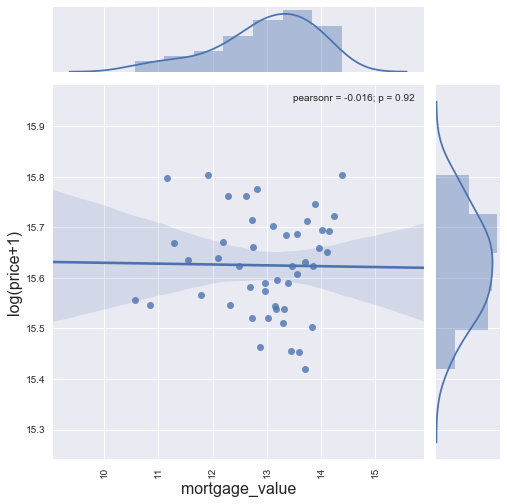

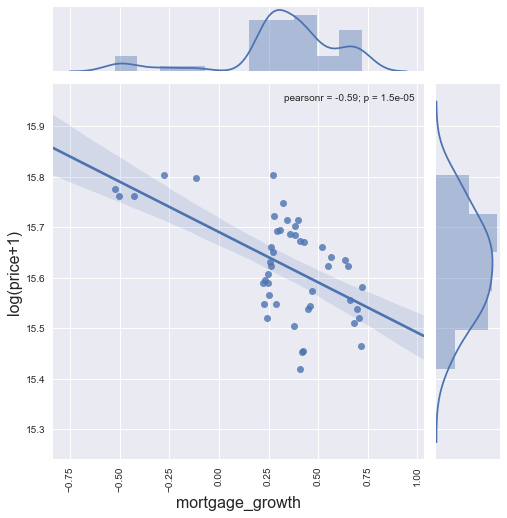

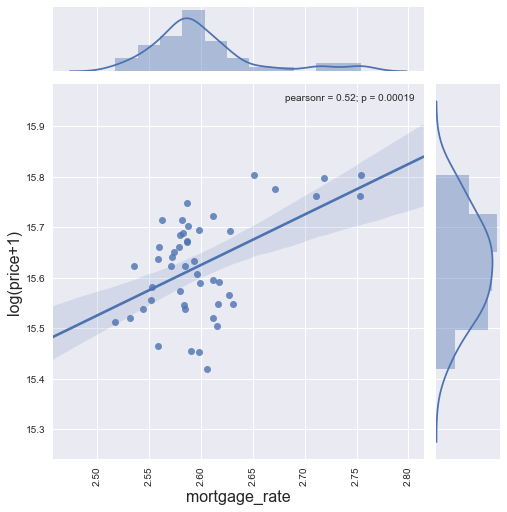

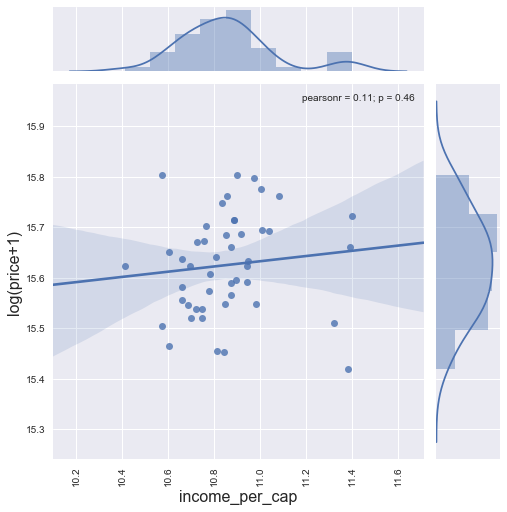

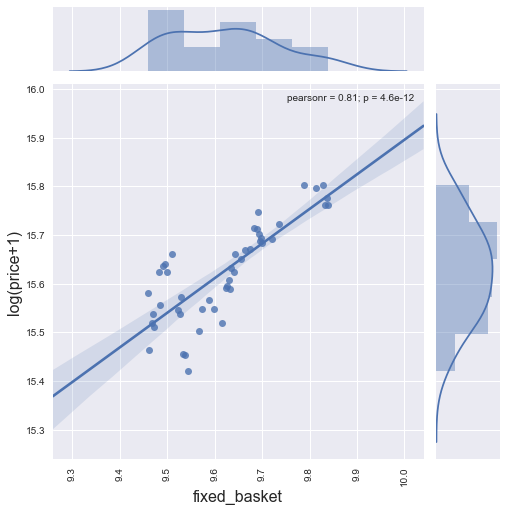

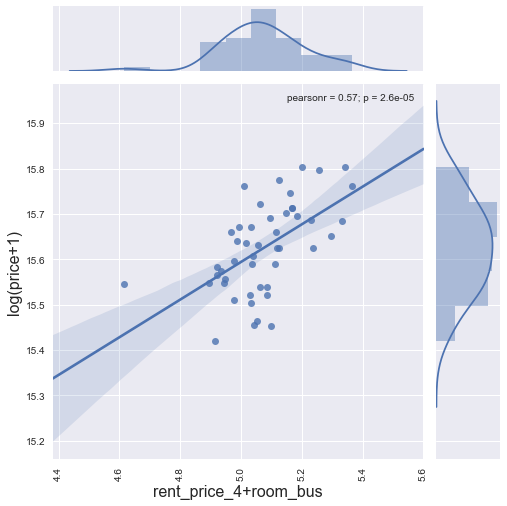

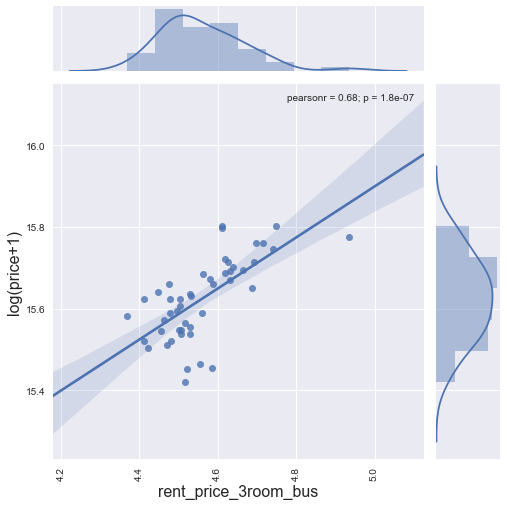

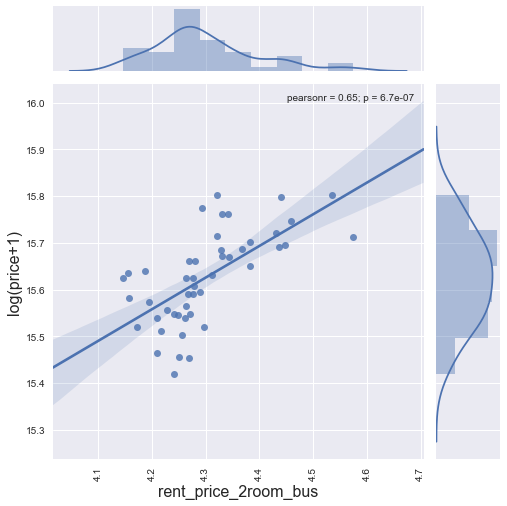

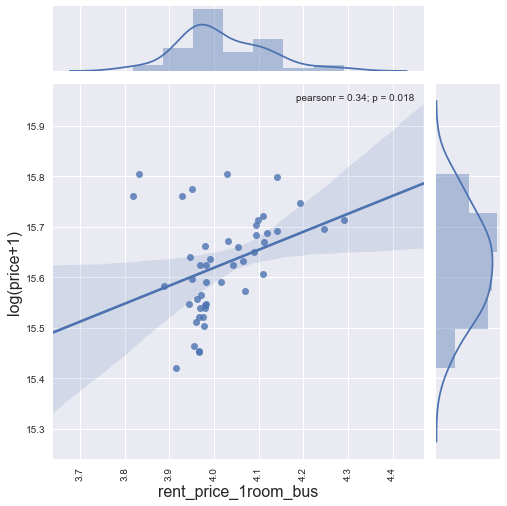

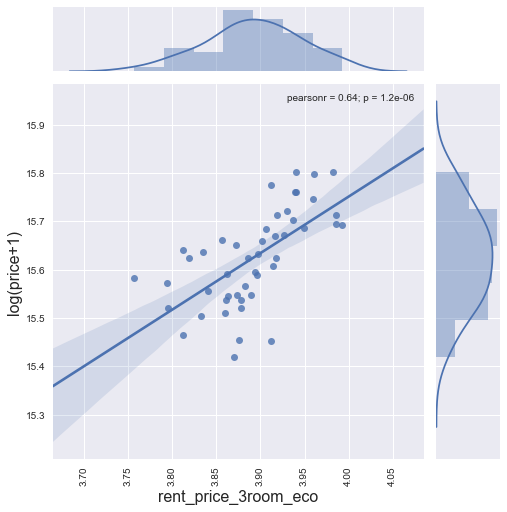

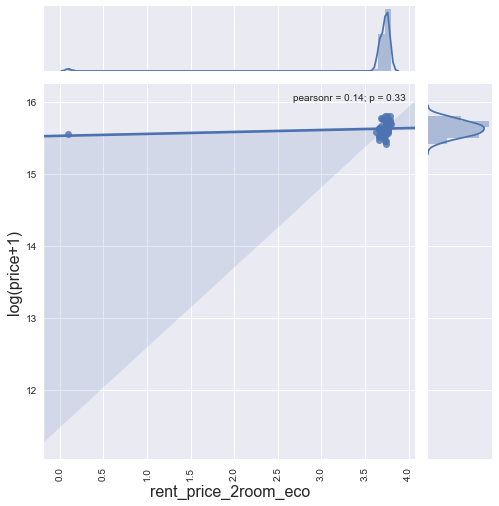

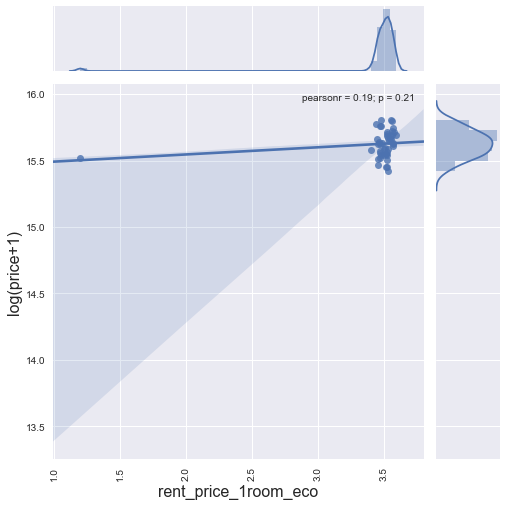

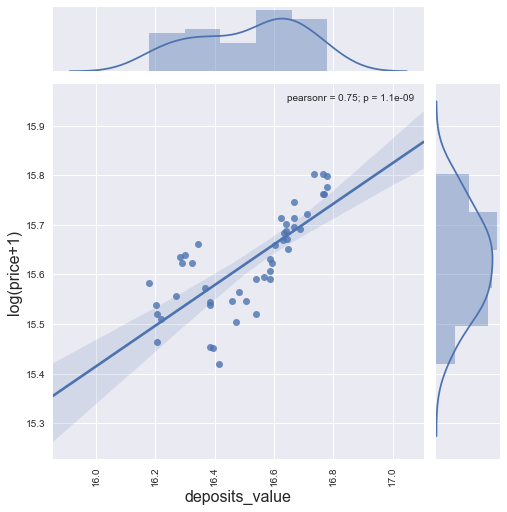

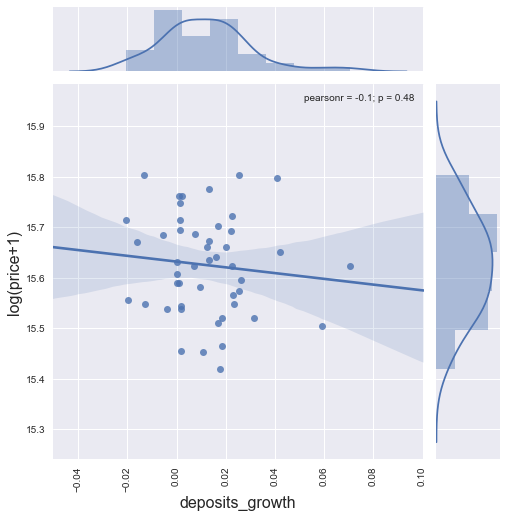

In [29]:
for col in monthlycol:
    plt.figure(figsize=(24,8))
    sns.jointplot(x = np.log1p(df_median[col]), y = np.log1p(df_median.price_doc), kind="reg", size=7)
    plt.xlabel(col, fontsize = 16)
    plt.ylabel('log(price+1)', fontsize = 16)
    plt.xticks(rotation='vertical')
    plt.show()

## price_doc log plots

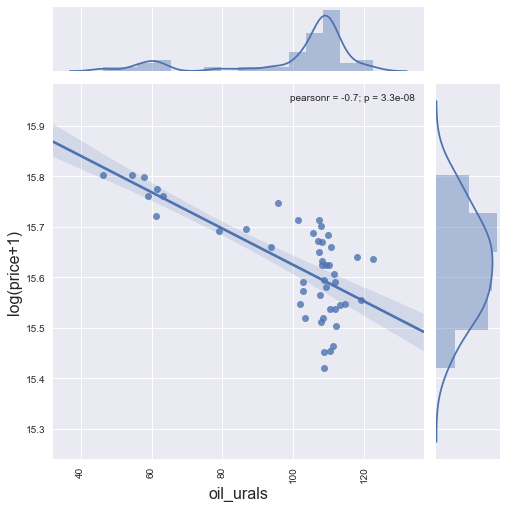

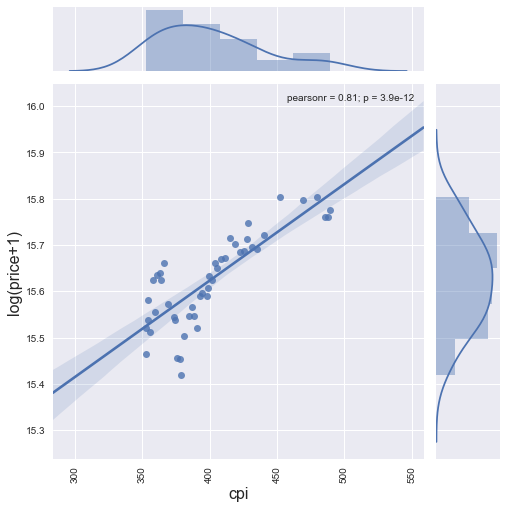

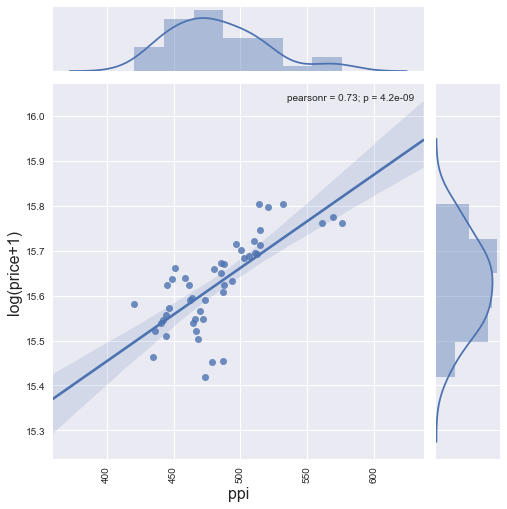

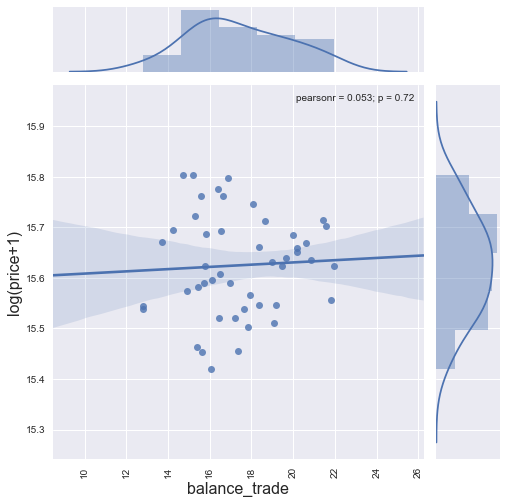

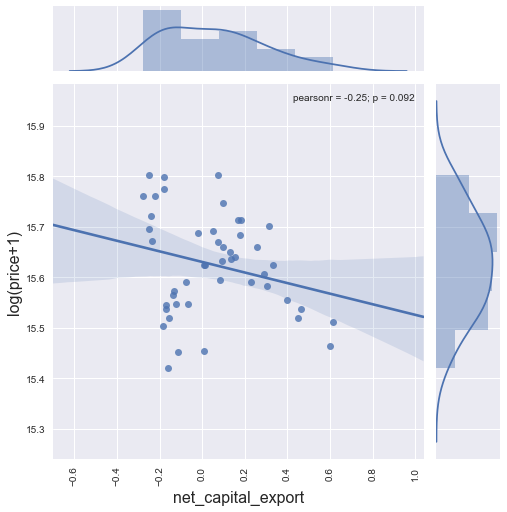

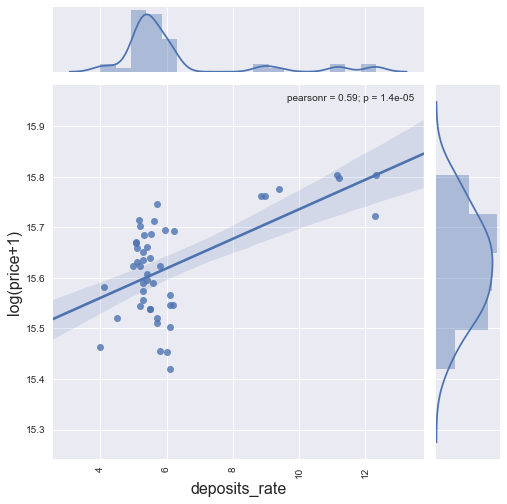

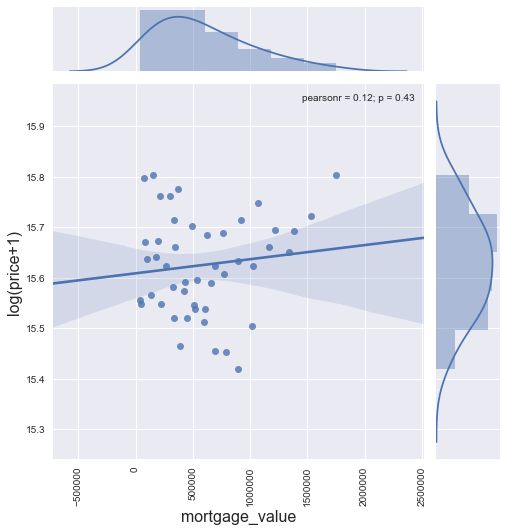

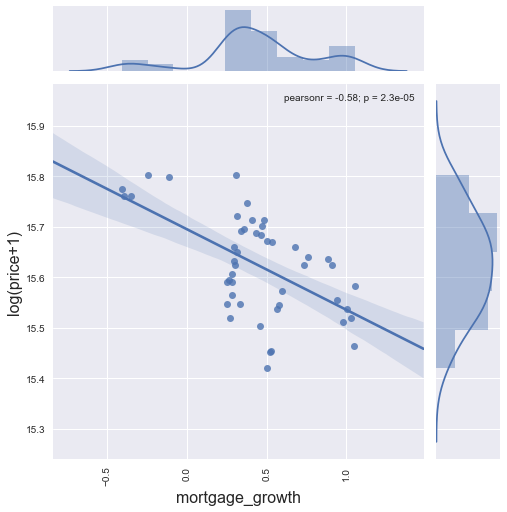

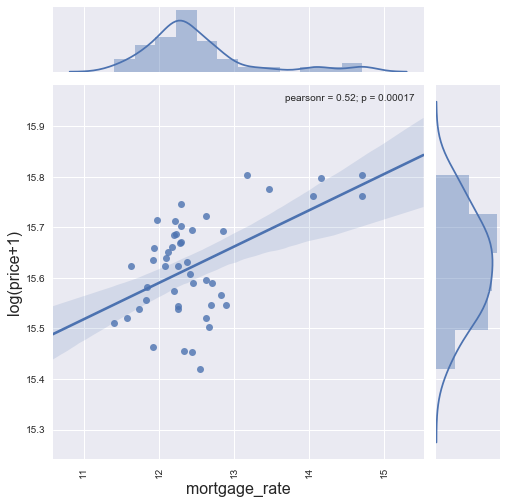

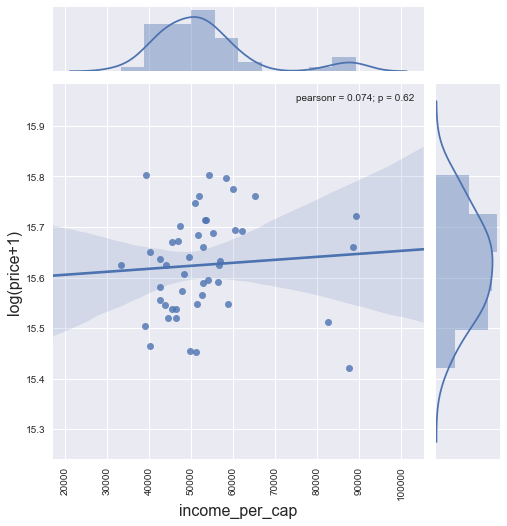

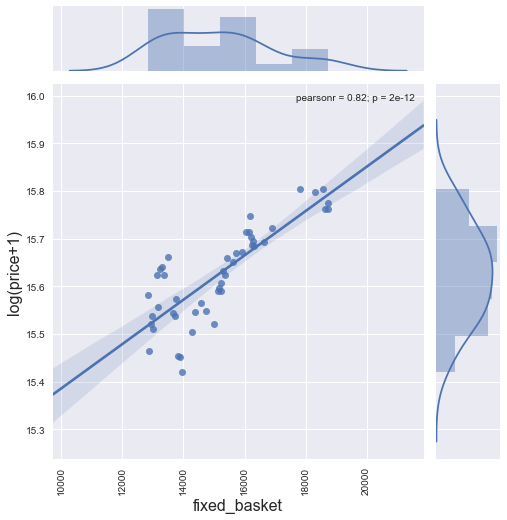

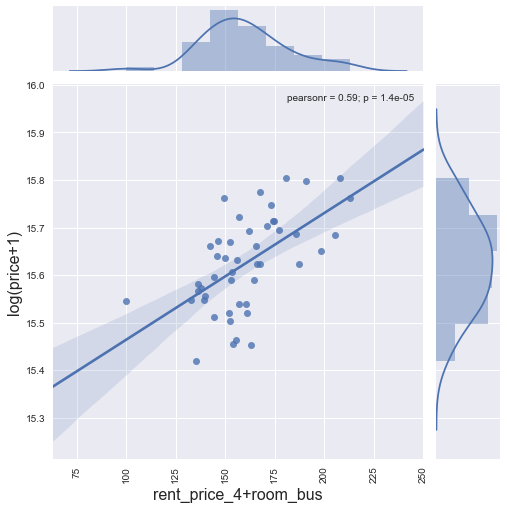

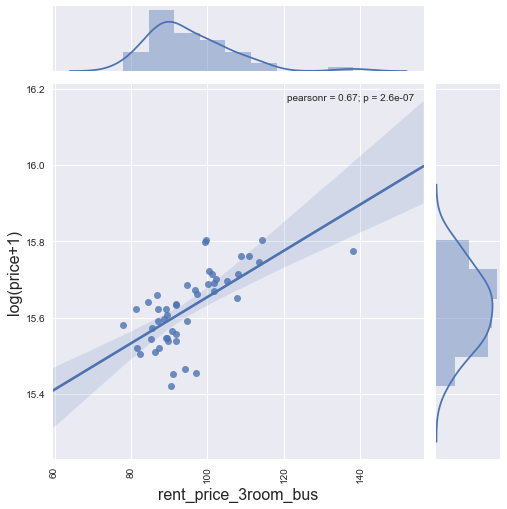

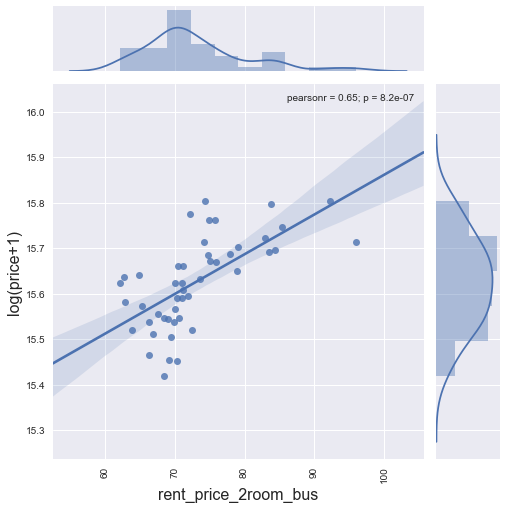

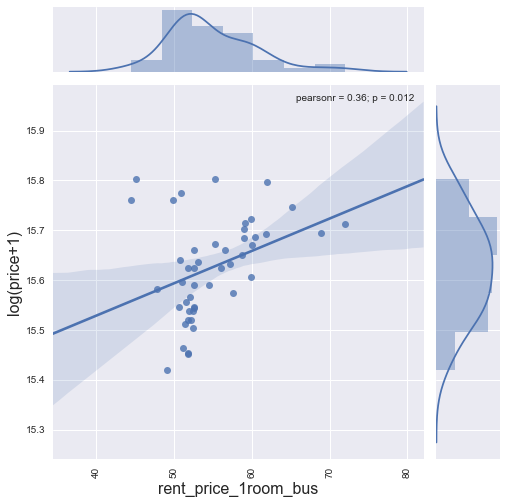

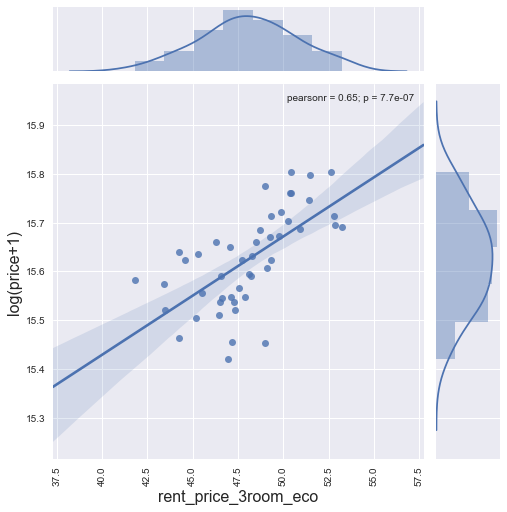

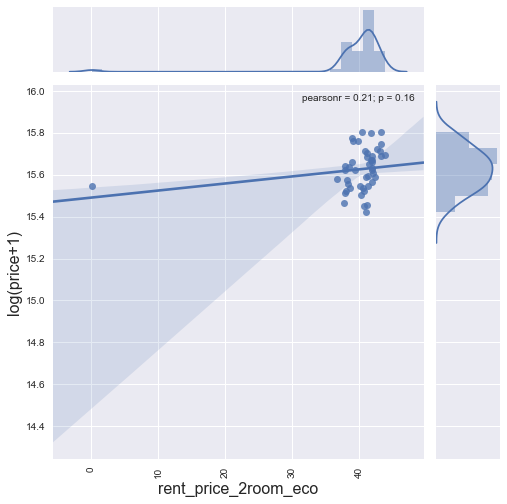

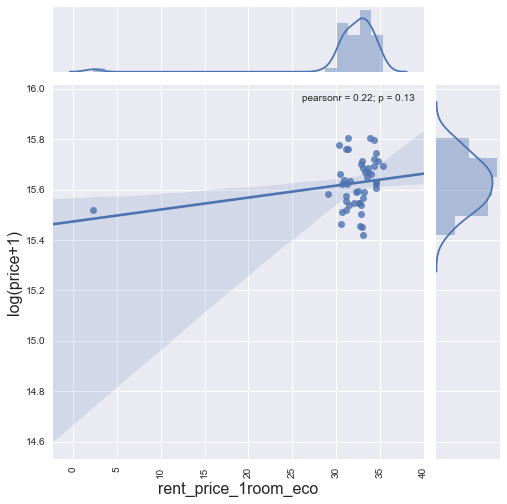

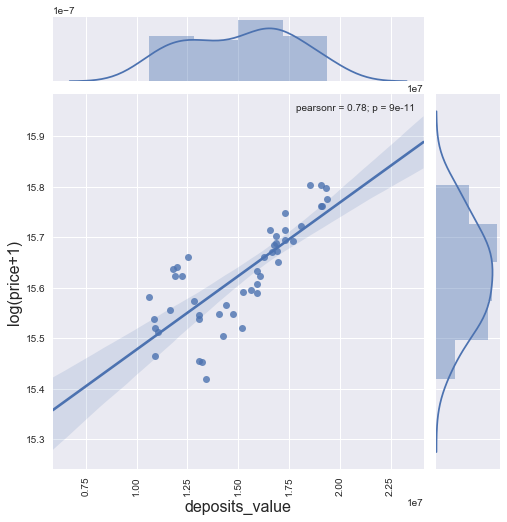

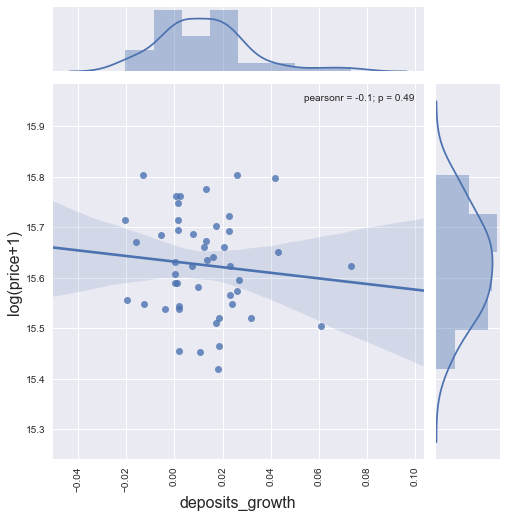

In [30]:
for col in monthlycol:
    plt.figure(figsize=(24,8))
    sns.jointplot(x = df_median[col], y = np.log1p(df_median.price_doc), kind="reg", size=7)
    plt.xlabel(col, fontsize = 16)
    plt.ylabel('log(price+1)', fontsize = 16)
    plt.xticks(rotation='vertical')
    plt.show()

## unit_price log-log plots

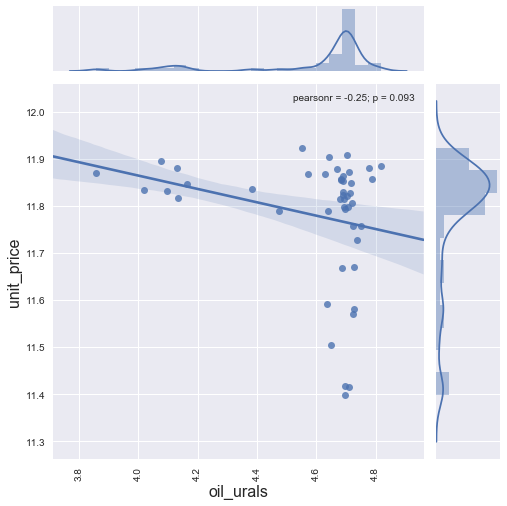

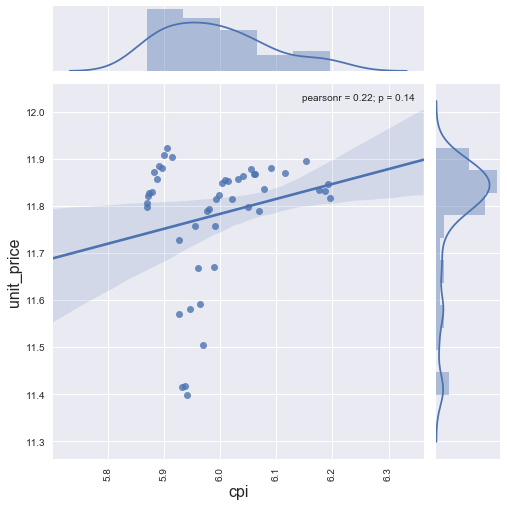

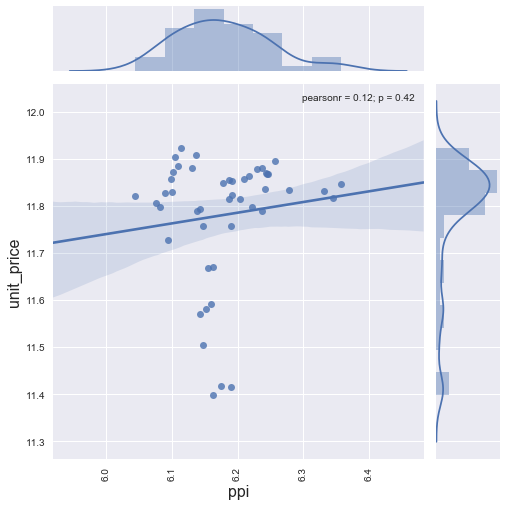

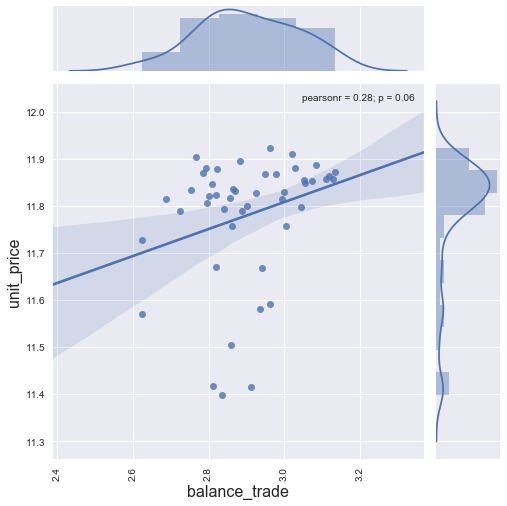

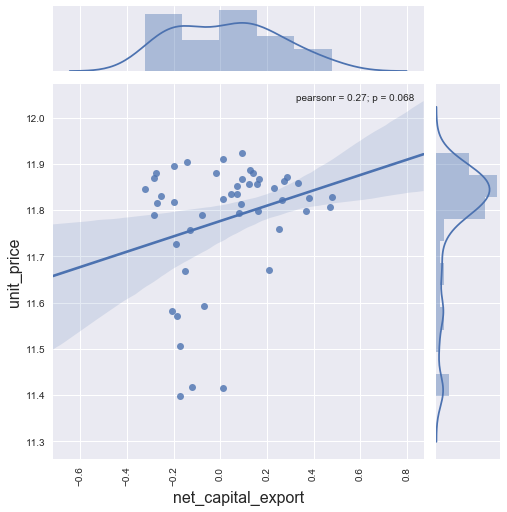

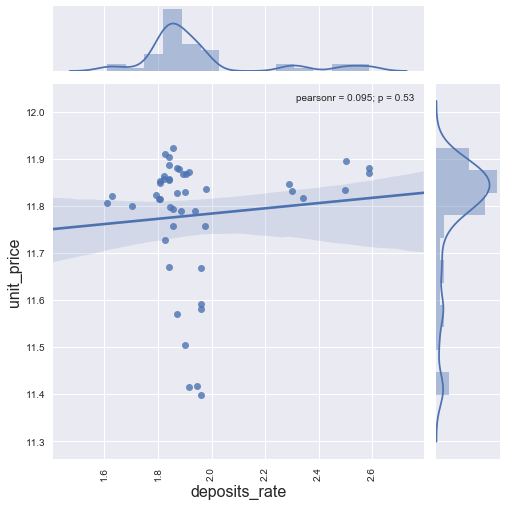

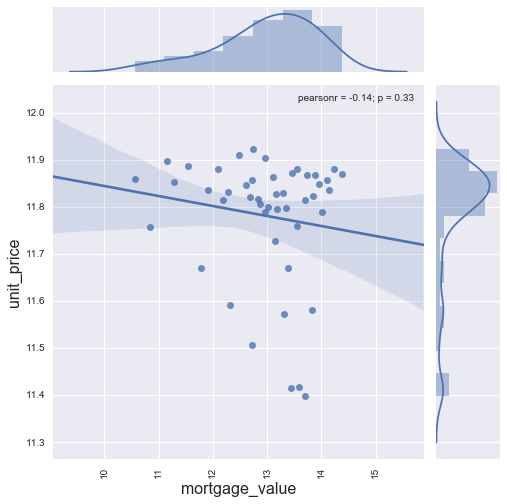

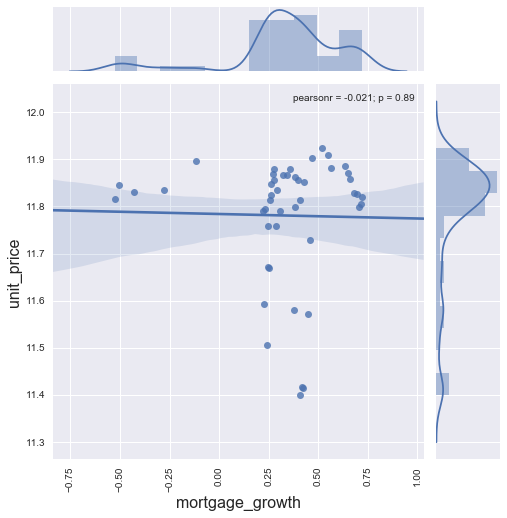

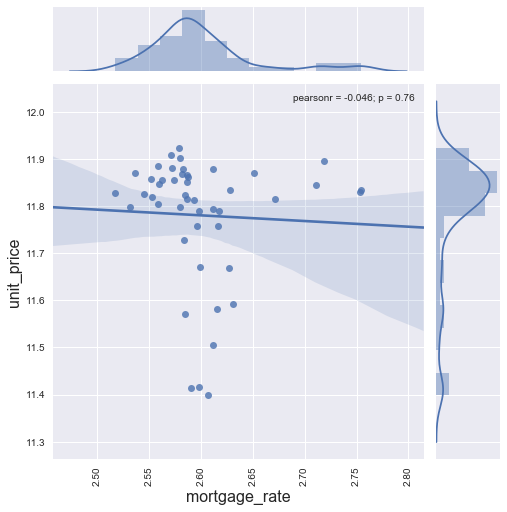

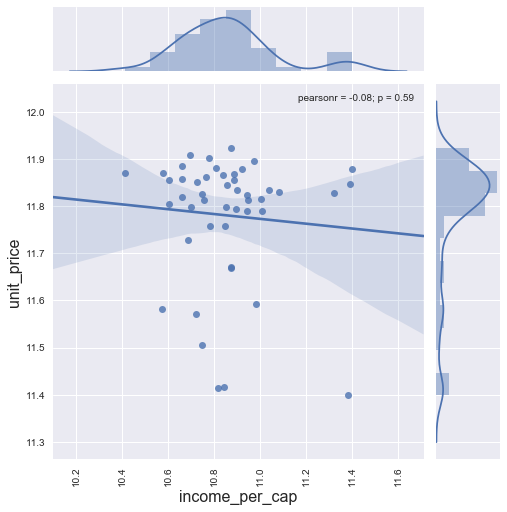

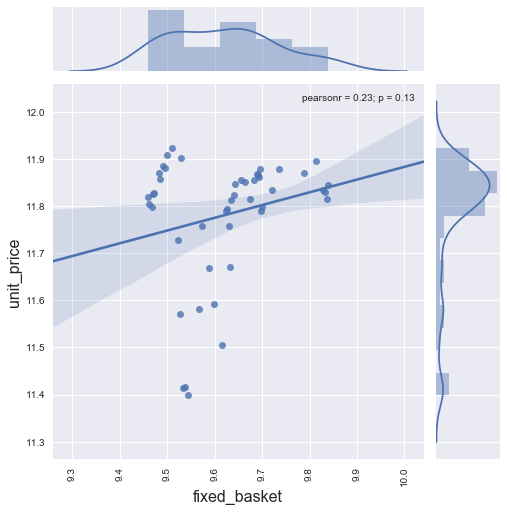

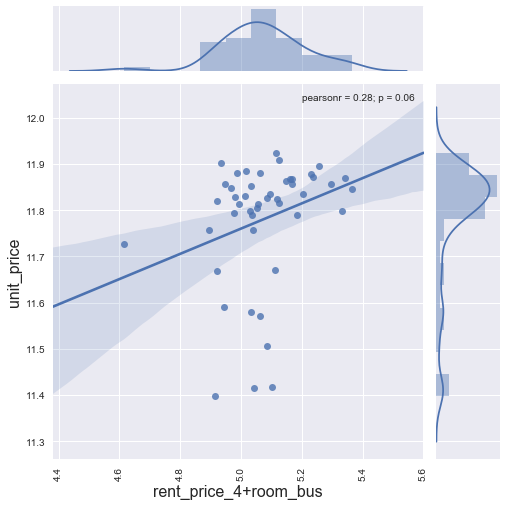

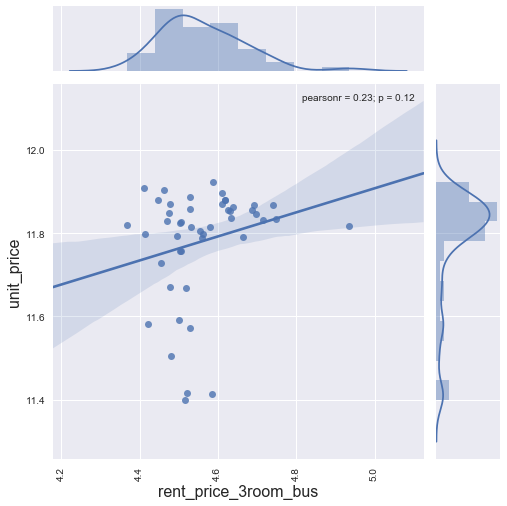

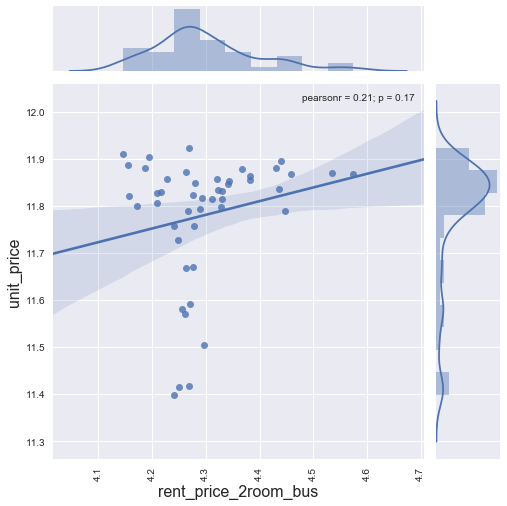

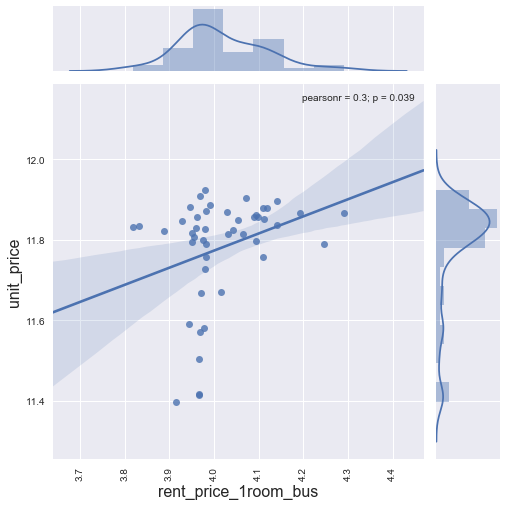

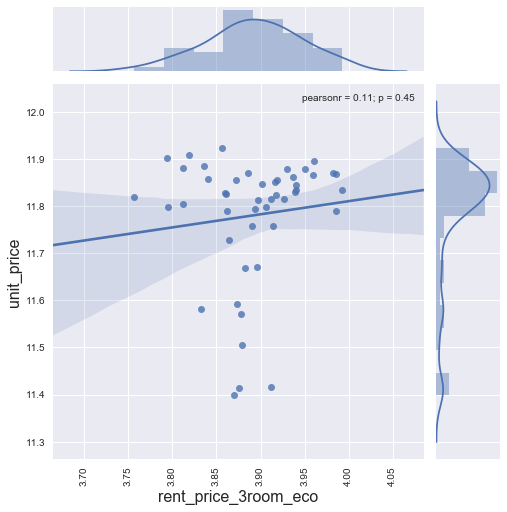

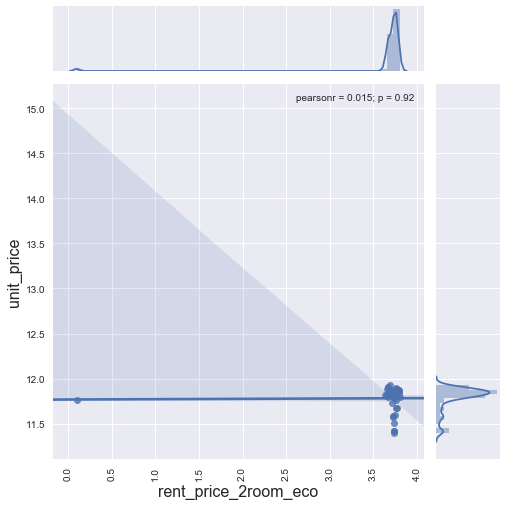

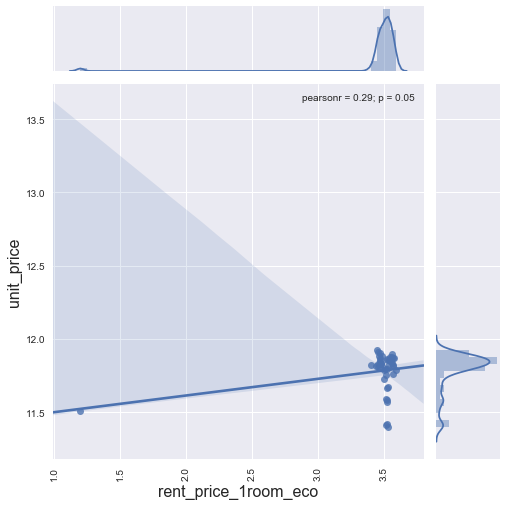

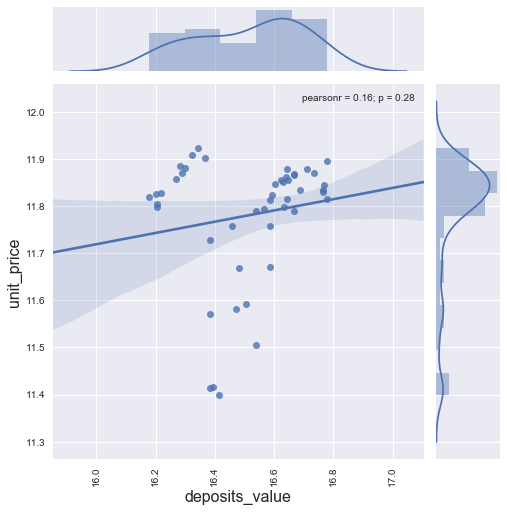

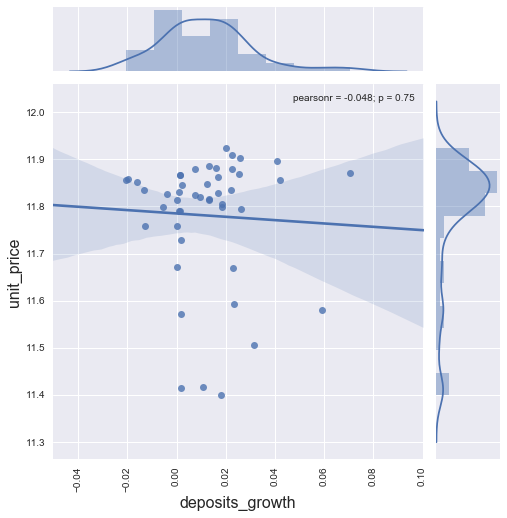

In [31]:
for col in monthlycol:
    plt.figure(figsize=(24,8))
    sns.jointplot(x = np.log1p(df_median[col]), y = np.log1p(df_median.unit_price), kind="reg", size=7)
    plt.xlabel(col, fontsize = 16)
    plt.ylabel('unit_price', fontsize = 16)
    plt.xticks(rotation='vertical')
    plt.show()

## Unit price plots (no log)

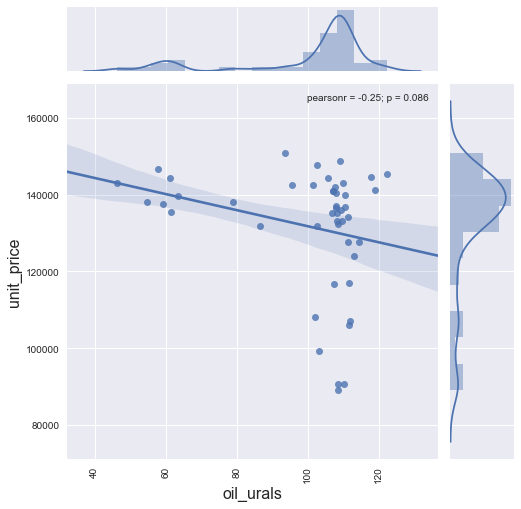

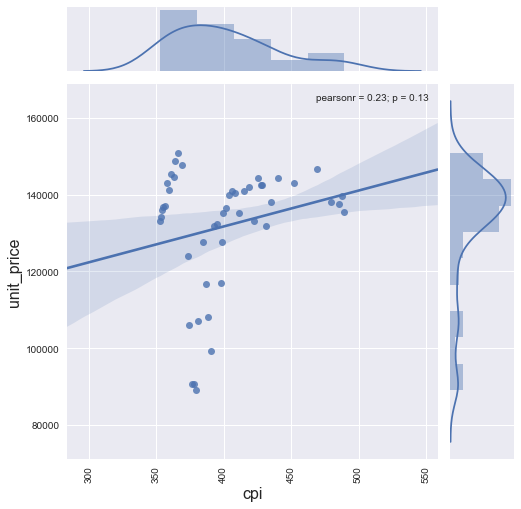

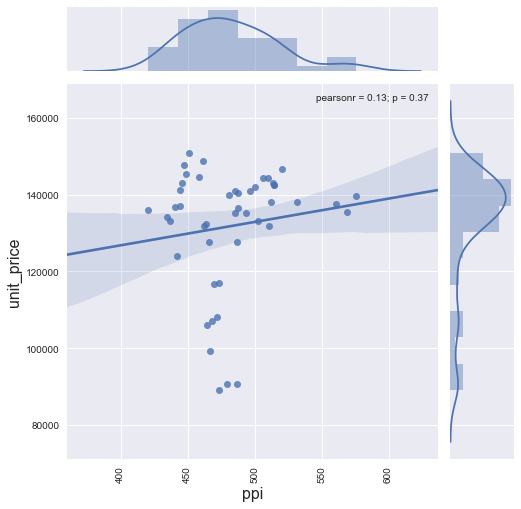

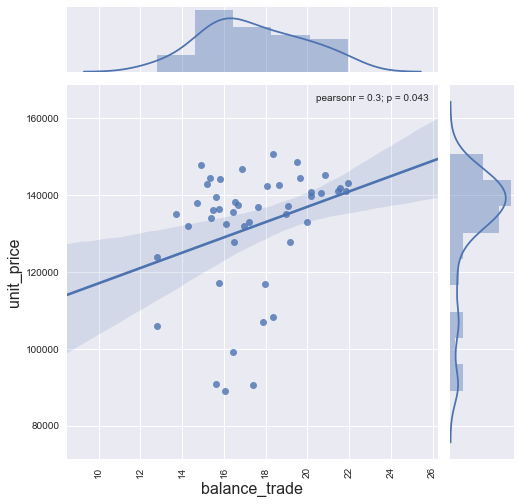

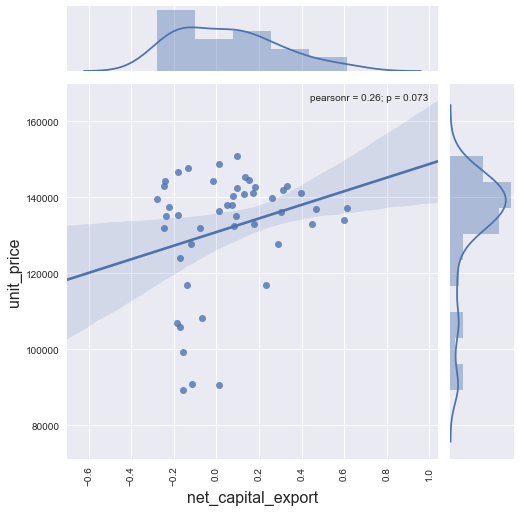

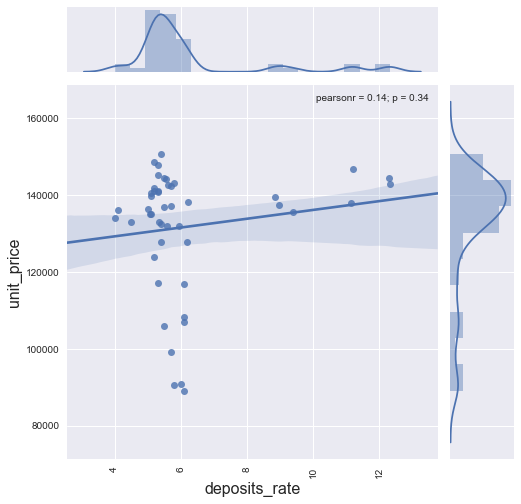

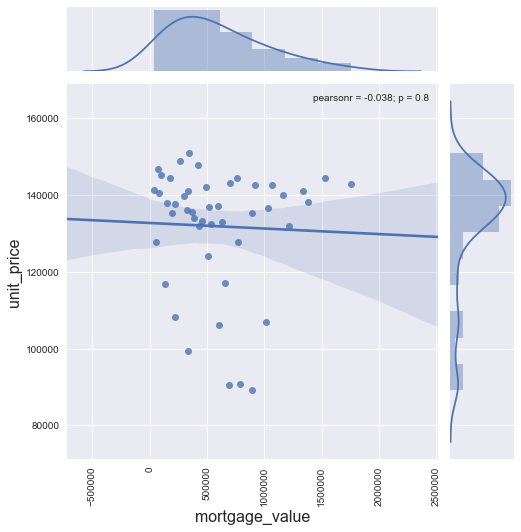

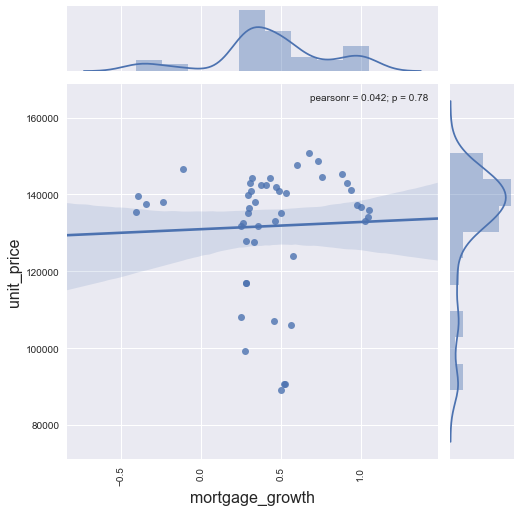

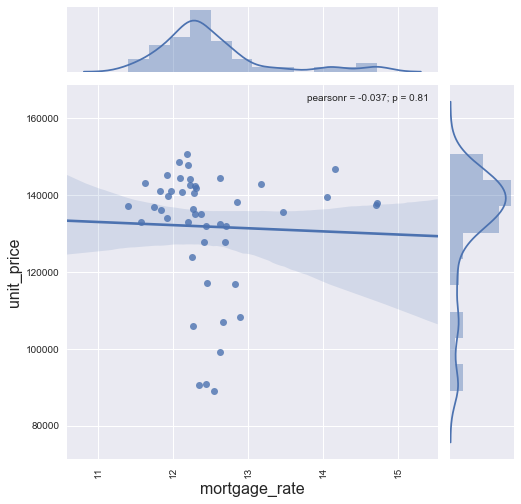

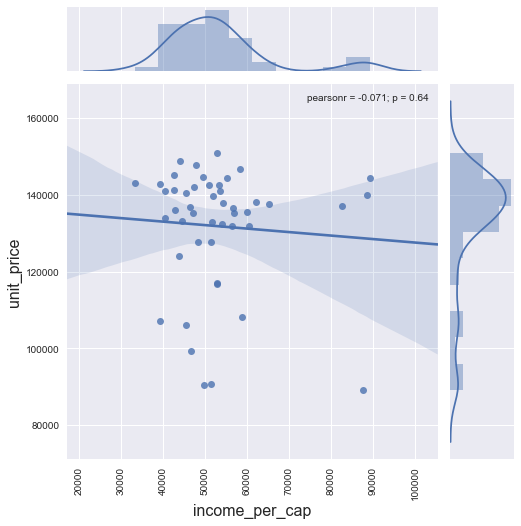

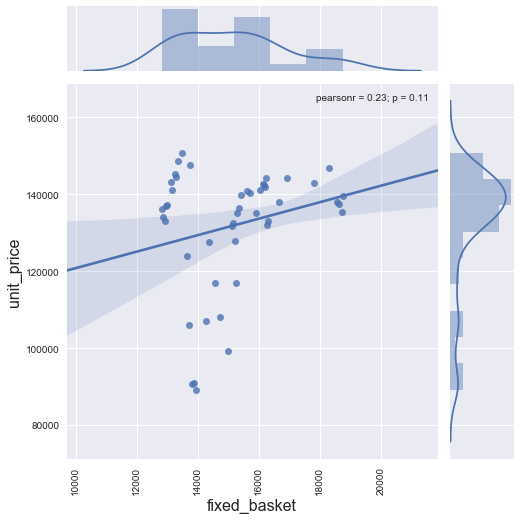

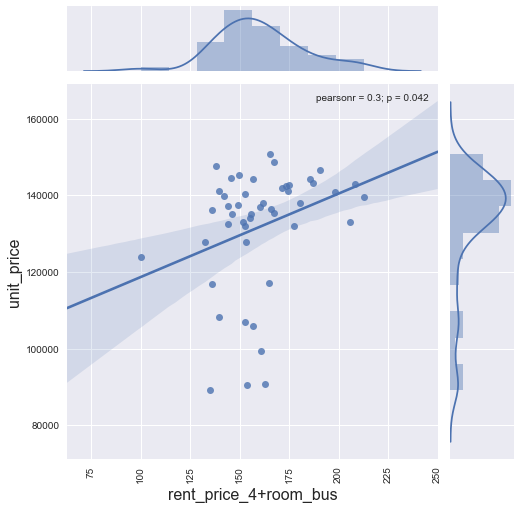

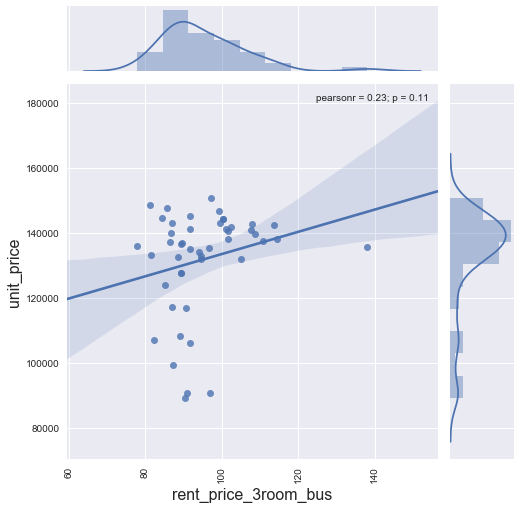

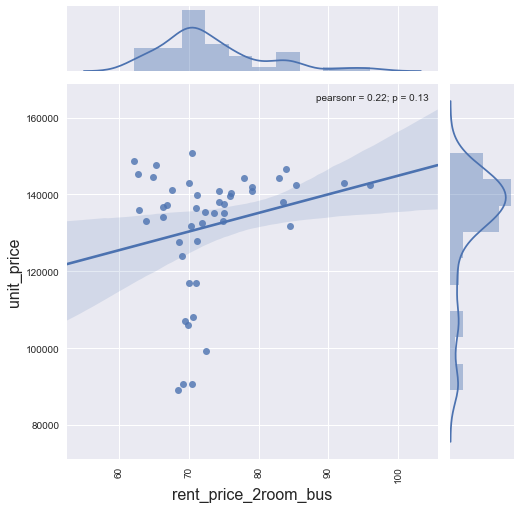

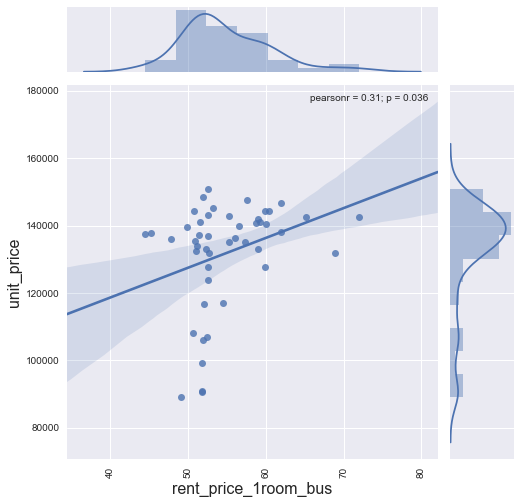

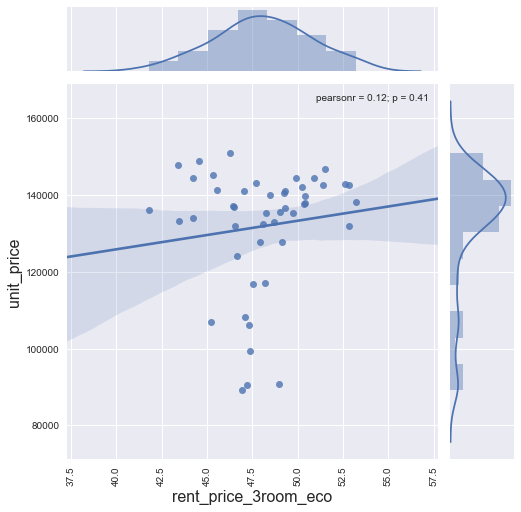

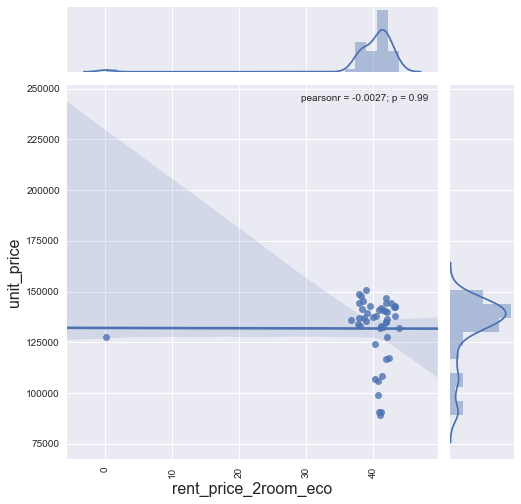

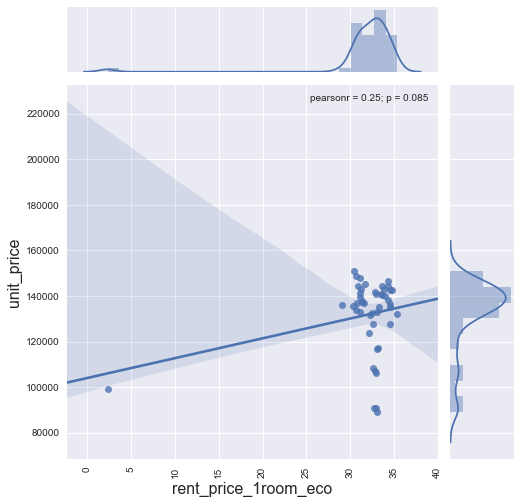

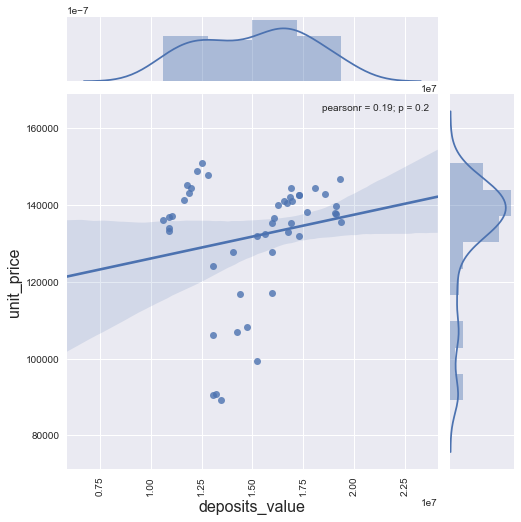

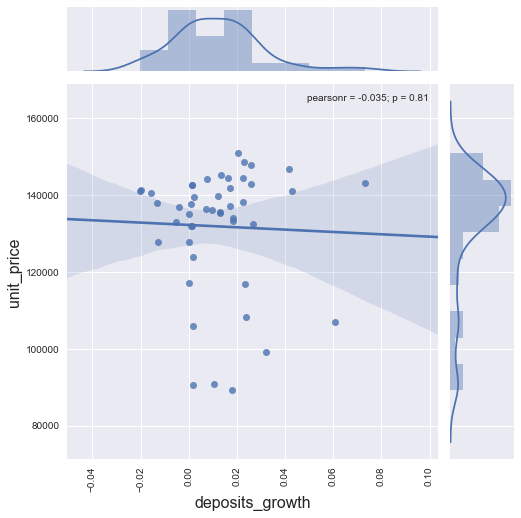

In [32]:
for col in monthlycol:
    plt.figure(figsize=(24,8))
    sns.jointplot(x = df_median[col], y = df_median.unit_price, kind="reg", size=7)
    plt.xlabel(col, fontsize = 16)
    plt.ylabel('unit_price', fontsize = 16)
    plt.xticks(rotation='vertical')
    plt.show()

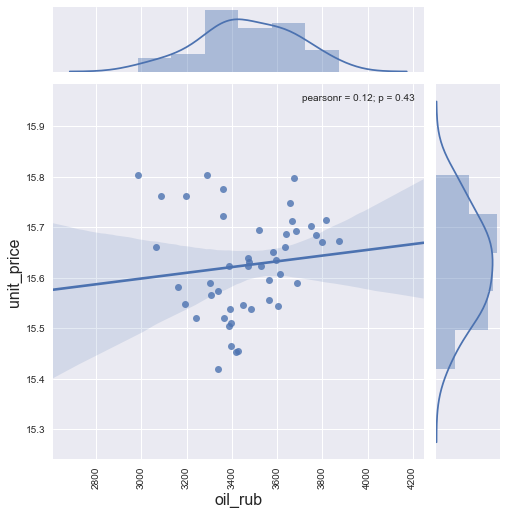

In [33]:
col = 'oil_rub'
plt.figure(figsize=(24,8))
sns.jointplot(x = df_median[col], y = np.log1p(df_median.price_doc), kind="reg", size=7)
plt.xlabel(col, fontsize = 16)
plt.ylabel('unit_price', fontsize = 16)
plt.xticks(rotation='vertical')
plt.show()

In [34]:
min(df_median.yearmonth)

'201001'

In [35]:
df_median.loc[:,['yearmonth','oil_rub']]

yearmonth      oil_rub
0     201001  2265.877500
1     201002  2197.801672
2     201003  2274.449404
3     201004  2415.867675
4     201005  2236.425750
5     201006  2306.609368
6     201007  2247.795288
7     201008  2300.552020
8     201009  2387.228200
9     201010  2479.284356
10    201011  2632.078290
11    201012  2759.012228
12    201101  2815.022190
13    201102  2955.624192
14    201103  3158.076267
15    201104  3353.972511
16    201105  3116.921300
17    201106  3120.721890
18    201107  3223.983996
19    201108  3160.447237
20    201109  3395.552497
21    201110  3366.101640
22    201111  3391.901622
23    201112  3397.878900
24    201201  3470.748971
25    201202  3563.484431
26    201203  3595.006344
27    201204  3472.939360
28    201205  3385.462080
29    201206  3065.766700
..       ...          ...
52    201405  3749.345228
53    201406  3772.754621
54    201407  3641.257127
55    201408  3668.133389
56    201409  3657.596003
57    201410  3520.953552
58    201411  3683.755638
59    201412  3361.266438
60    201501  2983.436161
61    201502  3673.988040
62    201503  3290.630341
63    201504  3087.485277
64    201505  3198.781170
65    201506  3359.142068
66    201507  3183.221409
67    201508  2960.423836
68    201509  3126.049641
69    201510  2964.130718
70    201511  2756.812905
71    201512  2588.615268
72    201601  2226.917019
73    201602  2367.365518
74    201603  2552.501145
75    201604  2657.925593
76    201605  2968.452362
77    201606  3037.993207
78    201607  2790.880349
79    201608  2835.572258
80    201609  2872.710966
81    201610  2789.796608

[82 rows x 2 columns]

In [36]:
df_median['oil_rub_shift_5m'] = df_median['oil_rub']

In [37]:
df_median.oil_rub_shift_5m[5:] = df_median.oil_rub[:-5]

/Users/chao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


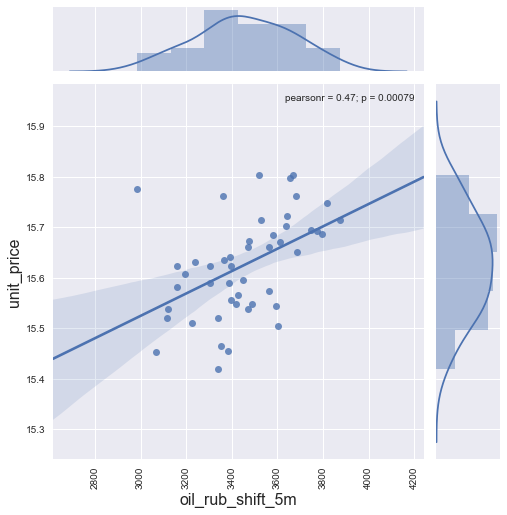

In [38]:
col = 'oil_rub_shift_5m'
plt.figure(figsize=(24,8))
sns.jointplot(x = df_median[col], y = np.log1p(df_median.price_doc), kind="reg", size=7)
plt.xlabel(col, fontsize = 16)
plt.ylabel('unit_price', fontsize = 16)
plt.xticks(rotation='vertical')
plt.show()

In [39]:
df_shift = df

In [41]:
df_shift['oil_rub_shift_153'] = df['oil_rub']
df_shift.oil_rub_shift_153[153:] = df.oil_rub[:-153]

/Users/chao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [42]:
df_shift['ppi_shift_90'] = df['ppi']
df_shift.ppi_shift_90[90:] = df.ppi[:-90]

/Users/chao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [43]:
df_shift['balance_trade_shift_91'] = df['balance_trade']
df_shift.balance_trade_shift_91[91:] = df.balance_trade[:-91]

/Users/chao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [44]:
df_shift['gdp_quart_shift_136'] = df['gdp_quart']
df_shift.gdp_quart_shift_136[136:] = df.gdp_quart[:-136]

/Users/chao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [46]:
df_shift.to_csv('macro_feature_CS_0521.csv',index=False)